In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')

Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***DATA PREPARATION***

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
rating_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/rating.csv")
links_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/link.csv")
genome_tags_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/genome_tags.csv")
genome_scores_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/genome_scores.csv")
tags_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/tag.csv")
movies_df_pd = pd.read_csv(r"/Users/evantheodar/Downloads/archive/movie.csv")

In [47]:
display(movies_df_pd.head())
display(links_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_scores_df_pd.head())
display(genome_tags_df_pd.head())



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [50]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [52]:
# Basic statistics for each dataset
print("\nRatings dataset statistics:")
print(rating_df_pd.describe())

print("\nMovies dataset statistics:")
print(movies_df_pd.describe())

print("\nTags dataset statistics:")
print(tags_df_pd.describe())

print("\nLinks dataset statistics:")
print(links_df_pd.describe())

print("\nGenome scores dataset statistics:")
print(genome_scores_df_pd.describe())

print("\nGenome tags dataset statistics:")
print(genome_tags_df_pd.describe())



Ratings dataset statistics:
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

Movies dataset statistics:
             movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000

Tags dataset statistics:
              userId        movieId
count  465564.000000  465564.000000
mean    68712.354263   32627.762920
std     41877.674053   36080.241157
min        18.000000       1.000000
25%     28780.000000    2571.000000
50%     70201.000000    7373.000000
75%    107322.000000   62235.000000
max    1

In [54]:
# Check unique values for linking columns
print("\nUnique movieId in ratings:", rating_df_pd['movieId'].nunique())
print("Unique movieId in movies:", movies_df_pd['movieId'].nunique())
print("Unique movieId in tags:", tags_df_pd['movieId'].nunique())
print("Unique movieId in links:", links_df_pd['movieId'].nunique())
print("Unique movieId in genome scores:", genome_scores_df_pd['movieId'].nunique())



Unique movieId in ratings: 26744
Unique movieId in movies: 27278
Unique movieId in tags: 19545
Unique movieId in links: 27278
Unique movieId in genome scores: 10381


In [56]:
# Common movieId across datasets
common_movie_ids = set(rating_df_pd['movieId']) & set(movies_df_pd['movieId']) & set(tags_df_pd['movieId']) & set(links_df_pd['movieId'])
print("\nNumber of common movieIds across datasets:", len(common_movie_ids))



Number of common movieIds across datasets: 19011


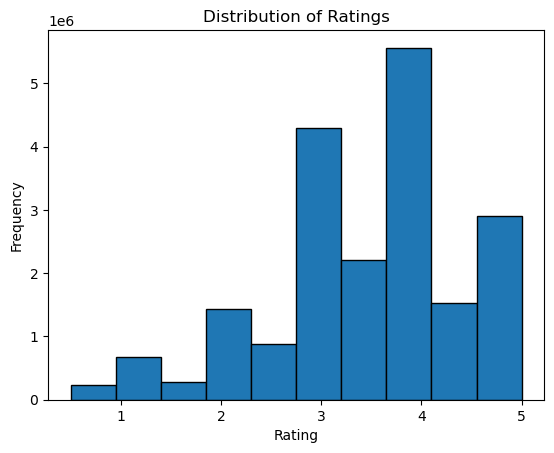

In [58]:
import matplotlib.pyplot as plt

# Distribution of ratings
plt.hist(rating_df_pd['rating'], bins=10, edgecolor='k')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()



This histogram illustrates the frequency distribution of movie ratings. The majority of ratings are clustered between 3 and 5, indicating that viewers tend to rate movies positively. Ratings below 3 are significantly less common, suggesting fewer negative experiences with the movies

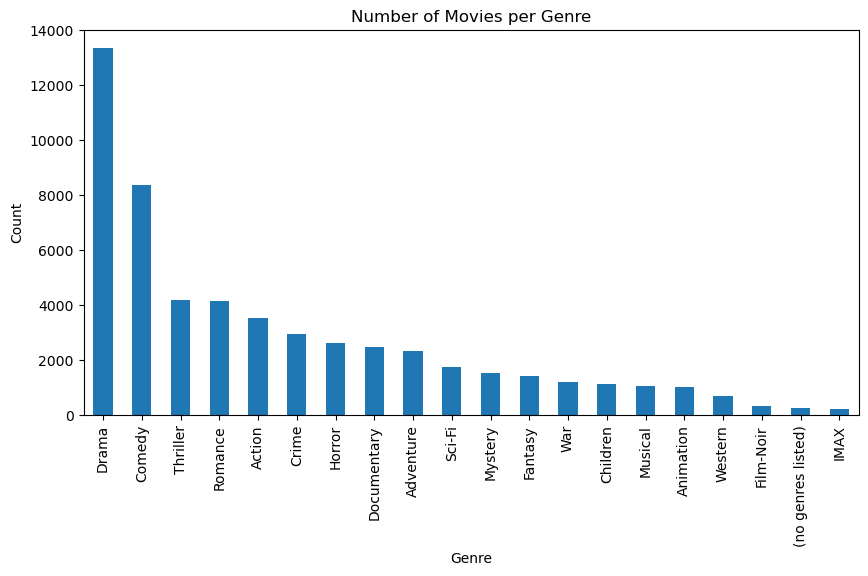

In [61]:
# Number of movies per genre
movies_df_pd['genres'].str.split('|').explode().value_counts().plot(kind='bar', figsize=(10, 5))
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


This bar chart shows the distribution of the number of movies across genres. Drama and Comedy dominate the dataset, accounting for the highest number of movies, while genres like Film-Noir, Western, and IMAX are represented less frequently. This highlights the diversity and focus of movie production.

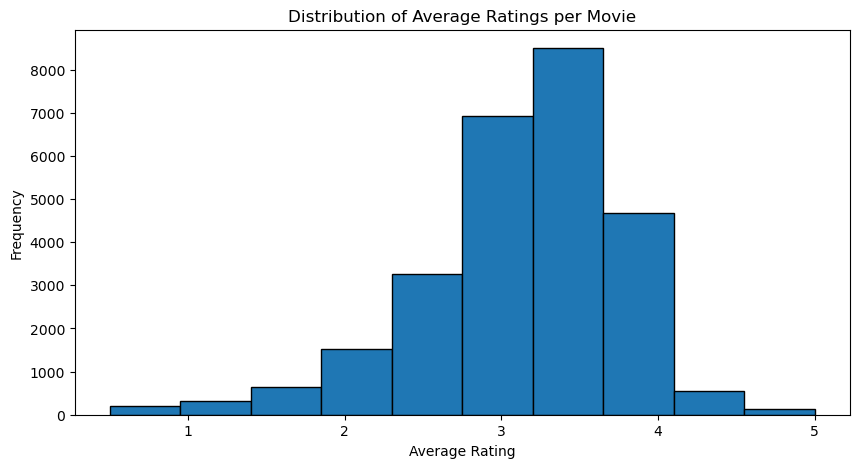

In [64]:

# 4. Average Rating per Movie
average_rating_per_movie = rating_df_pd.groupby('movieId')['rating'].mean()
average_rating_per_movie.plot(kind='hist', bins=10, edgecolor='k', figsize=(10, 5))
plt.title("Distribution of Average Ratings per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

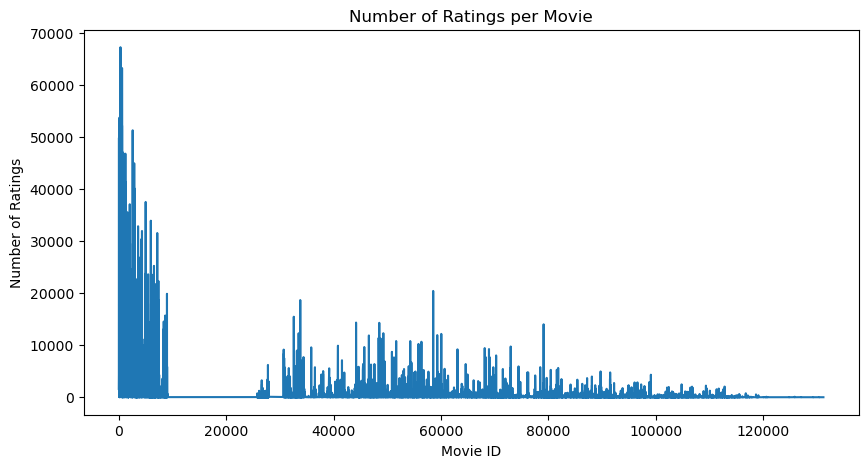

In [66]:
# Ratings distribution by movie
movie_ratings_count = rating_df_pd.groupby('movieId')['rating'].count()
movie_ratings_count.plot(kind='line', figsize=(10, 5))
plt.title("Number of Ratings per Movie")
plt.xlabel("Movie ID")
plt.ylabel("Number of Ratings")
plt.show()

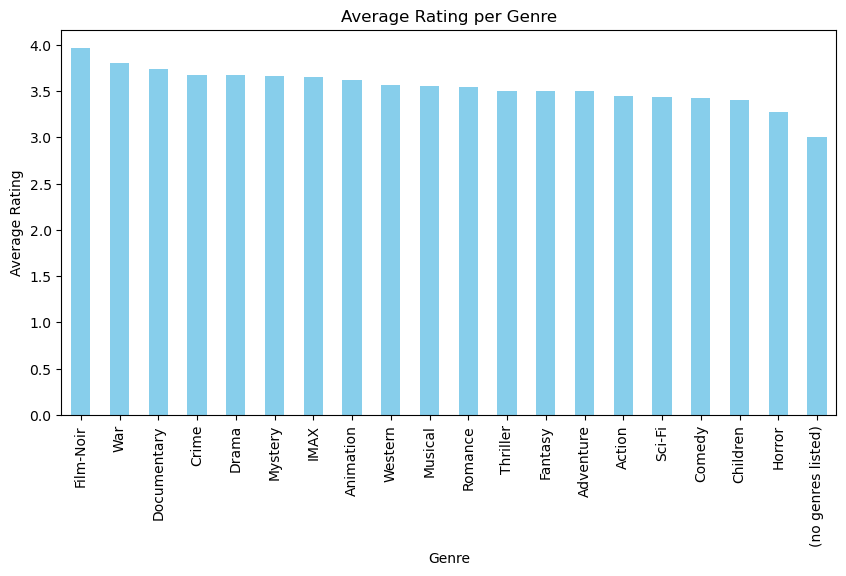

In [68]:
# Average rating per genre
movies_df_pd['genres_split'] = movies_df_pd['genres'].str.split('|')
genre_avg_rating = (
    movies_df_pd.explode('genres_split')
    .merge(rating_df_pd, on='movieId')
    .groupby('genres_split')['rating']
    .mean()
    .sort_values(ascending=False)
)
genre_avg_rating.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title("Average Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

This bar chart displays the average rating for each movie genre. Film-Noir and War genres have the highest average ratings, indicating a strong viewer preference, while Horror and genres with no labels tend to have lower ratings. This provides insights into audience preferences across genres.

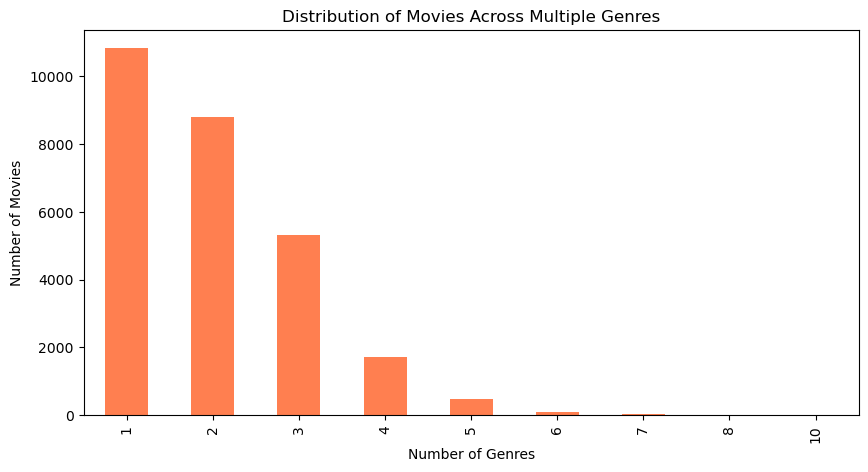

In [71]:
# Distribution of movies across multiple genres
movies_df_pd['number_of_genres'] = movies_df_pd['genres_split'].apply(len)
movies_df_pd['number_of_genres'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), color='coral')
plt.title("Distribution of Movies Across Multiple Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.show()

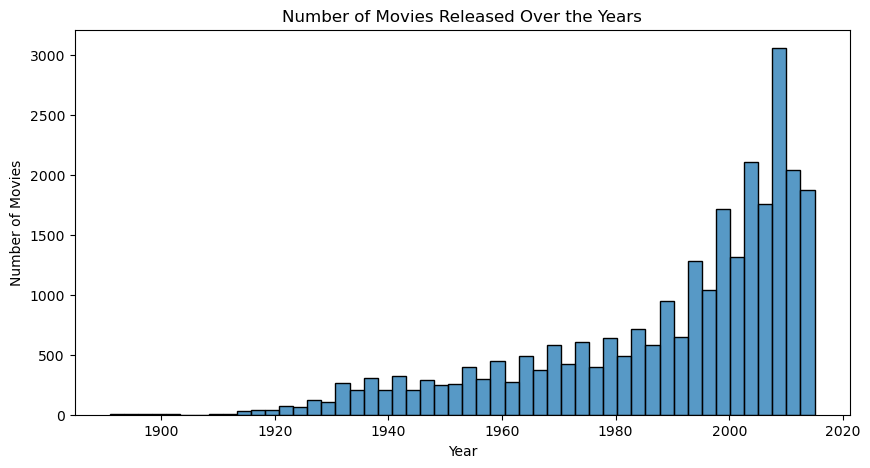

In [73]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

This bar chart shows the number of movies released each year over time. There is a noticeable increase in the number of movies produced starting from the 1980s, with a significant peak around the 2000s. This trend highlights the growth of the film industry over the decades.

1.2 Minhash Signatures
Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

Important: Implement your MinHash function from scratch—do not use any pre-built hash functions.

Use your MinHash function to generate signature vectors for each user based on their rated movies.


This code calculates user similarity based on the movies they have rated, using both exact **Jaccard similarity** and an efficient approximation with **MinHash signatures**. The dataset is processed to group movies by user, generate MinHash signatures, and compare all user pairs for their similarity. The results include both the exact and estimated similarity measures, providing insights into user preferences for applications like recommendation systems and clustering. MinHash is used to improve computational efficiency, making this approach scalable for large datasets.


In [80]:
import pandas as pd
import random
from itertools import combinations

In [82]:
# File path
file_path = r"/Users/evantheodar/Downloads/archive/rating.csv"

# Load the dataset
ratings_subset = pd.read_csv(file_path)

In [84]:
# Group movies rated by each user into a dictionary
user_movies = ratings_subset.groupby('userId')['movieId'].apply(set).to_dict()

In [86]:
# MinHash function to generate signatures
def minhash_signature(user_movies, num_hashes):
    """
    Generates a MinHash signature for a user.
    - user_movies: Set of movie IDs rated by the user.
    - num_hashes: Number of hash functions to use.
    """
    signature = []
    for i in range(num_hashes):
        random.seed(i)  # To ensure reproducible results
        a, b = random.randint(1, 100003), random.randint(0, 100003)
        hash_func = lambda x: (a * x + b) % 100003  # Random hash function
        min_hash = min(hash_func(movie) for movie in user_movies)
        signature.append(min_hash)
    return signature

In [88]:
# Generate MinHash signatures for each user
num_hashes = 100  # Number of hash functions
user_signatures = {user: minhash_signature(movies, num_hashes) for user, movies in user_movies.items()}

In [90]:
# Function for Jaccard and MinHash similarity
def jaccard_similarity(set1, set2):
    """Calculates the Jaccard similarity between two sets."""
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

In [92]:
# Function for MinHash similarity
def minhash_similarity(signature1, signature2):
    """Calculates the estimated similarity using MinHash."""
    return sum(1 for i, j in zip(signature1, signature2) if i == j) / len(signature1)

In [94]:
# Filter the first 500 users
selected_users = list(user_movies.keys())[:500]

# Generate combinations of pairs for the first 500 users
user_pairs = list(combinations(selected_users, 2))

# Compute intersection, union, Jaccard, and MinHash similarity for selected pairs
results = []
for user1, user2 in user_pairs:
    # Intersection and union
    common_movies = user_movies[user1] & user_movies[user2]
    all_movies = user_movies[user1] | user_movies[user2]

    num_common = len(common_movies)  # Intersection
    num_union = len(all_movies)  # Union

    # Jaccard similarity
    jaccard = jaccard_similarity(user_movies[user1], user_movies[user2])

    # Estimated similarity using MinHash
    minhash_sim = minhash_similarity(user_signatures[user1], user_signatures[user2])

    # Save results
    results.append((user1, user2, num_common, num_union, jaccard, minhash_sim))

# Create a DataFrame with the results
results_df = pd.DataFrame(results, columns=['User1', 'User2', 'Intersection', 'Union', 'JaccardSimilarity', 'MinHashSimilarity'])

# Display the results
print(results_df)


        User1  User2  Intersection  Union  JaccardSimilarity  \
0           1      2             9    227           0.039648   
1           1      3            42    320           0.131250   
2           1      4             3    200           0.015000   
3           1      5            14    227           0.061674   
4           1      6             2    197           0.010152   
...       ...    ...           ...    ...                ...   
124745    497    499             5    109           0.045872   
124746    497    500             3    207           0.014493   
124747    498    499             5     65           0.076923   
124748    498    500             0    166           0.000000   
124749    499    500             5    171           0.029240   

        MinHashSimilarity  
0                    0.04  
1                    0.09  
2                    0.01  
3                    0.04  
4                    0.01  
...                   ...  
124745               0.06  
124746 

Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.

In this implementation, three hashing methods—**linear**, **polynomial**, and **MD5**—were applied to generate MinHash signatures for each user. While the linear hashing method was already implemented, polynomial and MD5 hashing were added for comparison. These MinHash signatures were then used to estimate the similarity between user pairs.

The dataset contains user pairs along with their computed **Jaccard Similarity** (exact) and **MinHash Similarity** (estimated) for all three hashing methods. The results were compared using the Mean Absolute Error (MAE) to evaluate how closely each MinHash method approximates the Jaccard similarity. The comparison revealed slight differences in the accuracy of the hashing techniques, as shown in the MAE table.


In [98]:
import hashlib

def polynomial_hash(movie, coeffA, coeffB, i, prime):
    """Polynomial hash function"""
    hash_value = 0
    for power, coeff in enumerate(coeffA[:i+1]):
        hash_value += coeff * (movie ** power)
    return (hash_value + coeffB[i]) % prime

def md5_hash(movie, seed):
    """Hash function based on MD5."""
    hash_object = hashlib.md5(f"{movie}_{seed}".encode())
    return int(hash_object.hexdigest(), 16) % nextPrime


In [100]:
import random
import hashlib

# Constants for hash functions
nextPrime = 100003  # A large prime number
num_hashes = 100  # Number of hash functions

# Precompute coefficients for the hash functions
coeffA = [random.randint(1, nextPrime - 1) for _ in range(num_hashes)]
coeffB = [random.randint(0, nextPrime - 1) for _ in range(num_hashes)]

# Precompute hash values for all movies
def md5_hash(movie, seed):
    """Computes MD5 hash value for a given movie and seed."""
    hash_obj = hashlib.md5(f"{movie}-{seed}".encode('utf-8'))
    return int(hash_obj.hexdigest(), 16) % nextPrime

def polynomial_hash(movie, coeffA, coeffB, i, nextPrime):
    """Computes polynomial hash value for a given movie."""
    return (coeffA[i] * (movie ** 2) + coeffB[i]) % nextPrime

# Let's assume `all_movies` is the list of all unique movies
all_movies = set(movie for user_movies_list in user_movies.values() for movie in user_movies_list)

# Precompute hashes for all movies
precomputed_linear_hash = {}
precomputed_poly_hash = {}
precomputed_md5_hash = {}

for movie in all_movies:
    precomputed_linear_hash[movie] = [(coeffA[i] * movie + coeffB[i]) % nextPrime for i in range(num_hashes)]
    precomputed_poly_hash[movie] = [polynomial_hash(movie, coeffA, coeffB, i, nextPrime) for i in range(num_hashes)]
    precomputed_md5_hash[movie] = [md5_hash(movie, i) for i in range(num_hashes)]

# Structure to store MinHash signatures
minhash_signatures = {}

# Compute MinHash signatures for all users
for user, movies in user_movies.items():
    # Initialize the signature with the max possible hash value
    signature = {
        "linear": [nextPrime + 1] * num_hashes,
        "polynomial": [nextPrime + 1] * num_hashes,
        "md5": [nextPrime + 1] * num_hashes
    }
    
    for movie in movies:
        # Use precomputed hash values
        for i in range(num_hashes):
            signature["linear"][i] = min(signature["linear"][i], precomputed_linear_hash[movie][i])
            signature["polynomial"][i] = min(signature["polynomial"][i], precomputed_poly_hash[movie][i])
            signature["md5"][i] = min(signature["md5"][i], precomputed_md5_hash[movie][i])
    
    # Associate the signature with the user
    minhash_signatures[user] = signature

# Example output
print("MinHash signatures computed successfully!")


MinHash signatures computed successfully!


In [102]:
from itertools import combinations
import pandas as pd

# Initialize the results list
results = []

# Limit to the first 500 users (you can adjust this number)
selected_users = list(user_movies.keys())[:500]

# Precompute Jaccard similarity to avoid recomputation
def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

jaccard_cache = {}
for user1, user2 in combinations(selected_users, 2):
    # Use frozenset to ensure unique cache keys
    pair = frozenset([user1, user2])
    jaccard_cache[pair] = jaccard_similarity(user_movies[user1], user_movies[user2])

# Compute similarities for each pair of selected users
for user1, user2 in combinations(selected_users, 2):
    pair = frozenset([user1, user2])
    jaccard = jaccard_cache[pair]  # Retrieve precomputed Jaccard similarity

    # Compute MinHash similarities for each type of signature
    for hash_type in ["linear", "polynomial", "md5"]:
        minhash_sim = sum(
            1 for h1, h2 in zip(
                minhash_signatures[user1][hash_type],
                minhash_signatures[user2][hash_type]
            ) if h1 == h2
        ) / num_hashes  # Ratio of matching hashes
        results.append((user1, user2, hash_type, jaccard, minhash_sim))

# Create a DataFrame with the results
results_df = pd.DataFrame(results, columns=['User1', 'User2', 'HashType', 'JaccardSimilarity', 'MinHashSimilarity'])

# Display the results
display(results_df)


,User1,User2,HashType,JaccardSimilarity,MinHashSimilarity
0,1,2,linear,0.039648,0.05
1,1,2,polynomial,0.039648,0.07
2,1,2,md5,0.039648,0.04
3,1,3,linear,0.131250,0.14
4,1,3,polynomial,0.131250,0.19
...,...,...,...,...,...
374245,498,500,polynomial,0.000000,0.00
374246,498,500,md5,0.000000,0.00
374247,499,500,linear,0.029240,0.03
374248,499,500,polynomial,0.029240,0.02


In [104]:
# Calculate MAE without reset_index
mae_results = results_df.groupby('HashType').apply(
    lambda x: abs(x['JaccardSimilarity'] - x['MinHashSimilarity']).mean()
)

# Manually create the DataFrame
mae_results_df = pd.DataFrame({
    'HashType': mae_results.index,
    'MAE': mae_results.values
})

display(mae_results_df)


/var/folders/52/x9qw8_515ygcgb6w56tslspr0000gn/T/ipykernel_1265/2587110957.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_results = results_df.groupby('HashType').apply(


,HashType,MAE
0,linear,0.013136
1,md5,0.013595
2,polynomial,0.013599


comments about the results

1.3.1

In [108]:
import hashlib
from collections import defaultdict

def create_buckets(user_signatures, num_bands, rows_per_band):
    """
    Creates buckets by dividing MinHash signatures into bands and hashing each band.
    
    Parameters:
    - user_signatures: Dictionary {user_id: MinHash_signature}.
    - num_bands: Number of bands to divide MinHash signatures into.
    - rows_per_band: Number of rows per band.
    
    Returns:
    - buckets: Dictionary {bucket_id: list_of_users}.
    """
    buckets = defaultdict(list)  # Buckets to group users

    # Loop through each user and their signature
    for user_id, signature in user_signatures.items():
        # Split the MinHash signature into bands
        for band in range(num_bands):
            # Extract rows for the current band
            start_idx = band * rows_per_band
            end_idx = start_idx + rows_per_band
            band_rows = tuple(signature[start_idx:end_idx])

            # Hash the band to create a unique bucket ID
            band_hash = hashlib.sha1(str(band_rows).encode()).hexdigest()

            # Add the user to the corresponding bucket
            buckets[band_hash].append(user_id)
    
    return buckets


In [110]:
# LSH Parameters
num_bands = 10
rows_per_band = num_hashes // num_bands  # Each band contains (70/10 = 7) rows

# Create buckets
buckets = create_buckets(user_signatures, num_bands, rows_per_band)

# Check the buckets
for bucket_id, users in list(buckets.items())[30:45]:
    print(f"Bucket {bucket_id}: {users}")



Bucket 9fe987db075a5909a45740efca1d14f7829a2370: [4]
Bucket 7950b03a5cf252c1d846461dcc884c8aa13d8881: [4]
Bucket 59526ee9af82f36d36ddfecfd052263536704dea: [4]
Bucket 7557f2e36ece2a700acc178bf84dbb1029b6629f: [4]
Bucket 0f4d15a749f8dc580e1e52ad5771b959f8314332: [4]
Bucket 74170bad3bf51a97733cecbd92b50e7fd3d9c02e: [4]
Bucket 1ccc8630c756cc1545127a503e59e594d300d3ff: [4]
Bucket 9b57321d2971e83078c9bded7e7acd76bf815925: [4]
Bucket d7fc4aec9f785a5b412a29dabb91e0986ee53516: [4]
Bucket 27fb550c77016d5983f87f7ec5cdd3bfd343c894: [4]
Bucket f1a83525a62572f1051ae824de447de116a21166: [5]
Bucket 532cf00ba17a8967a7d8ea086389851cbbb574f4: [5]
Bucket d668d78edcb31ef3471989bf96c4da4bc88a7ca9: [5]
Bucket 579397047b4e2d1a95a13039761813fa0f2e74ca: [5]
Bucket e4d3bc93bf33e56c33894242c7fcbfbe21990b61: [5]


In [111]:
# List of users in the bucket
bucket_users = [5, 64263, 99407]

# Check common movies
common_movies = set.intersection(*(user_movies[user] for user in bucket_users))

print(f"Common movies among users {bucket_users}: {common_movies}")




Common movies among users [5, 64263, 99407]: {1035, 1036, 11, 780, 141, 17, 788, 150, 1079, 440, 316, 318, 457, 587, 589, 590, 593, 595, 475, 480, 364, 500, 376, 377, 380}


In [112]:
# Define three users
user1, user2, user3 = 5, 64263, 99407

# Calculate Jaccard similarities between the users
jaccard_12 = len(user_movies[user1].intersection(user_movies[user2])) / len(user_movies[user1].union(user_movies[user2]))
jaccard_13 = len(user_movies[user1].intersection(user_movies[user3])) / len(user_movies[user1].union(user_movies[user3]))
jaccard_23 = len(user_movies[user2].intersection(user_movies[user3])) / len(user_movies[user2].union(user_movies[user3]))

# Print Jaccard similarity values
print(f"Jaccard Similarity (User {user1} - User {user2}): {jaccard_12}")
print(f"Jaccard Similarity (User {user1} - User {user3}): {jaccard_13}")
print(f"Jaccard Similarity (User {user2} - User {user3}): {jaccard_23}")


Jaccard Similarity (User 5 - User 64263): 0.3047619047619048
Jaccard Similarity (User 5 - User 99407): 0.3442622950819672
Jaccard Similarity (User 64263 - User 99407): 0.2706766917293233


In [113]:
# Calculate the number of buckets with more than 1, more than 3, and more than 6 users
buckets_more_than_1 = sum(1 for users in buckets.values() if len(users) > 1)
buckets_more_than_3 = sum(1 for users in buckets.values() if len(users) > 3)
buckets_more_than_6 = sum(1 for users in buckets.values() if len(users) > 6)

# Results
{
    "Buckets with more than 1 user": buckets_more_than_1,
    "Buckets with more than 3 users": buckets_more_than_3,
    "Buckets with more than 6 users": buckets_more_than_6
}

        


{'Buckets with more than 1 user': 11305,
 'Buckets with more than 3 users': 2407,
 'Buckets with more than 6 users': 976}

In [114]:
def find_top_2_similar_users_fixed_attempts(target_user, user_signatures, user_movies, num_hashes):
    """
    Finds the top 2 most similar users to a target user by trying different numbers of bands for LSH.
    
    Parameters:
    - target_user: The ID of the user for whom to find similar users.
    - user_signatures: Dictionary containing MinHash signatures for each user.
    - user_movies: Dictionary mapping users to the sets of movies they have rated.
    - num_hashes: Total number of hash functions used in the MinHash signatures.
    
    Returns:
    - A list of tuples containing the top 2 similar users and their Jaccard similarity scores, or None if no similar users are found.
    """
    # List of num_bands values to try
    num_bands_list = [10, 14, 35, 70]
    
    for num_bands in num_bands_list:
        rows_per_band = num_hashes // num_bands  # Calculate the number of rows per band
        
        print(f"\nTrying with num_bands={num_bands}, rows_per_band={rows_per_band}")
        
        # Regenerate buckets with the new parameters
        buckets = create_buckets(user_signatures, num_bands, rows_per_band)

        similar_users = set()

        # Search for similar users in the buckets
        for bucket_id, users in buckets.items():
            if target_user in users:
                similar_users.update(users)

        # Remove the target user from the set of similar users
        similar_users.discard(target_user)

        # If similar users are found, calculate Jaccard similarity and return the top 2
        if similar_users:
            jaccard_scores = {}
            for user in similar_users:
                intersection = len(user_movies[target_user].intersection(user_movies[user]))
                union = len(user_movies[target_user].union(user_movies[user]))
                jaccard_scores[user] = intersection / union

            # Sort users by Jaccard similarity
            top_2_users = sorted(jaccard_scores.items(), key=lambda x: x[1], reverse=True)[:2]
            print("Similar users found!")
            return top_2_users

        # If no similar users are found, try the next num_bands value
        print(f"No similar users found for {target_user} with num_bands={num_bands}.")
    
    # If no similar users are found after all attempts
    print(f"Unable to find similar users for {target_user} after trying all values of num_bands.")
    return None


In [115]:
# Initial parameters
num_bands = 10
rows_per_band = 70 // num_bands  # Initial calculation of rows per band

# Example: Find similar users for user 1941
target_user = 1941
top_2_similar_users = find_top_2_similar_users_fixed_attempts(target_user, user_signatures, user_movies, num_hashes)

if top_2_similar_users:
    print(f"The two most similar users to {target_user} are:")
    for user, score in top_2_similar_users:
        print(f"User {user} with Jaccard Similarity: {score:.2f}")



Trying with num_bands=10, rows_per_band=10
No similar users found for 1941 with num_bands=10.

Trying with num_bands=14, rows_per_band=7
Similar users found!
The two most similar users to 1941 are:
User 69269 with Jaccard Similarity: 0.21


In [158]:
data = pd.read_csv(r"/Users/evantheodar/Downloads/archive/rating.csv")

In [160]:
# Check the first few rows of the dataset
print(data.head())


# Creating the user_movies_ratings dictionary
user_movies_ratings = (
    data.groupby('userId')  # Group by user
    .apply(lambda x: dict(zip(x['movieId'], x['rating'])))  # Convert each group into a {movie: rating} dictionary
    .to_dict()  # Convert everything into a dictionary
)

# Print the result to verify
print(user_movies_ratings)



   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


/var/folders/52/x9qw8_515ygcgb6w56tslspr0000gn/T/ipykernel_1265/2873245897.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['movieId'], x['rating'])))  # Convert each group into a {movie: rating} dictionary
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [180]:
def recommend_movies(target_user, top_2_similar_users, user_movies_ratings, movie_id_to_name, max_recommendations=5):
    recommendations = {}

    # If there are similar users, extract their movies
    if top_2_similar_users:
        for i, similar_user in enumerate(top_2_similar_users[:2]):  # Limit to top 2 similar users
            user_id = similar_user[0]
            if user_id in user_movies_ratings:
                # Add top-rated movies from this user
                user_ratings = sorted(user_movies_ratings[user_id].items(), key=lambda x: x[1], reverse=True)
                for movie, rating in user_ratings:
                    if movie not in user_movies_ratings[target_user]:
                        recommendations[movie] = max(recommendations.get(movie, 0), rating)
                    if len(recommendations) >= max_recommendations:
                        break

    # Fallback: If fewer than 5 recommendations, use globally popular movies
    if len(recommendations) < max_recommendations:
        print("Not enough recommendations from similar users, adding globally top-rated movies.")
        all_movies = {}
        for user_ratings in user_movies_ratings.values():
            for movie, rating in user_ratings.items():
                all_movies[movie] = max(all_movies.get(movie, 0), rating)
        global_recommendations = sorted(all_movies.items(), key=lambda x: x[1], reverse=True)
        for movie, rating in global_recommendations:
            if movie not in user_movies_ratings[target_user] and movie not in recommendations:
                recommendations[movie] = rating
                if len(recommendations) >= max_recommendations:
                    break

    # Convert movie IDs to titles and return exactly 5
    final_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:max_recommendations]
    final_recommendations_with_names = [(movie_id_to_name.get(movie, f"Unknown Movie ({movie})"), rating) 
                                        for movie, rating in final_recommendations]
    return final_recommendations_with_names

# Create a mapping from movieId to title using the `movie.csv` dataset



In [182]:

recommendations = recommend_movies(target_user, top_2_similar_users, user_movies_ratings, movie_id_to_name, max_recommendations=5)

# Display recommendations
print("\nRecommendations for user A:")
if recommendations:
    for movie, rating in recommendations:
        print(f"{movie}: {rating:.2f}")
else:
    print("No recommendations available.")


Recommendations for user A:
The Matrix: 5.00
The Godfather: 4.00
Star Wars: 4.00
Pulp Fiction: 4.00
Forrest Gump: 4.00


# 2. Grouping Movies Together!

## 2.1 Feature Engineering

In this section of the code, our goal is to group the movies together, which means we need to carefully select and combine the datasets we have. This is the first step in our process. We have decided to use several key features that can help represent the movies, such as:

- *Relevant genome tag*: The most relevant tag associated with each movie from the genome set.
- *Common user tag*: The most common tag provided by users for the movie.
- *Average rating* (ratings_avg): The average rating given by users.
- *Genres*: The genres associated with each movie.
- *Movie ID* (movieId): The unique identifier for each movie.

In addition to these features, we want to include the following:

- *Popularity quotient*: A measure that can reflect how popular a movie is based on the number of ratings it has received.
- *Release year*: The year in which the movie was released.
- *num_ratings*: Number of ratings per movie

In [1]:
import pandas as pd
# Carica i dataset
ratings = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\rating.csv")  # Contiene userId, movieId, rating, timestamp
tags = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\tag.csv")        # Contiene userId, movieId, tag, timestamp
movies = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\movie.csv")    # Contiene movieId, title, genres
relevance = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\genome_scores.csv")  # Contiene movieId, tagId, relevance
tag_names = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\genome_tags.csv") # Contiene tagId, tag
links = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\link.csv")      # Contiene movieId, imdbId

In [2]:
ratings_avg = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings_avg.columns = ['movieId', 'ratings_avg']

In [3]:
# Unisci relevance con i nomi dei tag
relevant_tags = relevance.merge(tag_names, on='tagId')

# Trova il tag con la massima rilevanza per ogni film
relevant_genome_tag = relevant_tags.loc[relevant_tags.groupby('movieId')['relevance'].idxmax()]
relevant_genome_tag = relevant_genome_tag[['movieId', 'tag']]
relevant_genome_tag.columns = ['movieId', 'relevant_genome_tag']
relevant_genome_tag


,movieId,relevant_genome_tag
10744335,1,toys
290669,2,adventure
4671452,3,good sequel
11574818,4,women
4671454,5,good sequel
...,...,...
851237,130578,assassination
8958799,130840,romance
2387627,131013,comedy
1328766,131168,betrayal


In [4]:
common_user_tag = tags.groupby(['movieId', 'tag']).size().reset_index(name='count')
common_user_tag = common_user_tag.loc[common_user_tag.groupby('movieId')['count'].idxmax()]
common_user_tag = common_user_tag[['movieId', 'tag']]
common_user_tag.columns = ['movieId', 'common_user_tag']
common_user_tag


,movieId,common_user_tag
19,1,Pixar
94,2,Robin Williams
129,3,moldy
135,4,characters
151,5,steve martin
...,...,...
200355,131054,dinosaurs
200356,131082,Yoshitomo Nara
200358,131164,Vietnam War
200359,131170,alternate reality


In [5]:
# Estrai l'anno di rilascio dal titolo del film
# Unisci il DataFrame movies con links usando movieId come chiave
movies = movies.merge(links[['movieId', 'imdbId']], on='movieId', how='left')

# Visualizza i primi film con l'imdbId aggiunto
print(movies[['movieId', 'title', 'imdbId']].head())

movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Gestisci il tipo di dato correttamente
# Converti la colonna 'release_year' in un tipo numerico, che può gestire NaN
movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

# Converti la colonna in Int64 di pandas, che gestisce NaN
movies['release_year'] = movies['release_year'].astype('Int64')




   movieId                               title  imdbId
0        1                    Toy Story (1995)  114709
1        2                      Jumanji (1995)  113497
2        3             Grumpier Old Men (1995)  113228
3        4            Waiting to Exhale (1995)  114885
4        5  Father of the Bride Part II (1995)  113041


In [45]:
# Unisci le feature
movies_features = movies[['movieId', 'release_year']].merge(ratings_avg, on='movieId', how='left')
movies_features = movies_features.merge(relevant_genome_tag, on='movieId', how='left')
movies_features = movies_features.merge(common_user_tag, on='movieId', how='left')


# Visualizza le prime righe del DataFrame risultante
movies_features


,movieId,release_year,ratings_avg,relevant_genome_tag,common_user_tag
0,1,1995,3.921240,toys,Pixar
1,2,1995,3.211977,adventure,Robin Williams
2,3,1995,3.151040,good sequel,moldy
3,4,1995,2.861393,women,characters
4,5,1995,3.064592,good sequel,steve martin
...,...,...,...,...,...
27273,131254,2007,4.000000,NaN,NaN
27274,131256,2002,4.000000,NaN,NaN
27275,131258,2014,2.500000,NaN,Korea
27276,131260,2001,3.000000,NaN,NaN


We noticed that some data was missing from the dataset, which could impact the quality and accuracy of our analysis. For the numerical fields, such as ratings and number of ratings, we decided to fill in the missing values by using the average of the existing data. This ensures that the dataset remains as complete as possible without introducing significant bias.

Regarding the release year of the films, we observed that some movies lacked this crucial information. We leveraged an API key to access IMDb's database. This allowed us to retrieve the missing release years for the films that were missing this data. Although this process only applied to a small subset of films, it helped improve the completeness of our dataset, ensuring that we could continue our analysis with more reliable and comprehensive information.

In [7]:
import pandas as pd
import requests

# Definisci la chiave API OMDb (sostituisci con la tua chiave)
api_key = '9ffe46d9'

# Funzione per ottenere l'anno di rilascio da IMDb utilizzando l'imdbId
def get_release_year(imdb_id):
    # Assicurati che l'imdb_id sia una stringa
    imdb_id = str(imdb_id)
    
    # Tentativo con "tt0"
    if not imdb_id.startswith('tt0'):
        imdb_id = 'tt0' + imdb_id
    
    url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    
    # Se la risposta è valida e contiene l'anno, restituiscilo
    if 'Year' in data:
        year = data['Year']
        
        # Gestisci i casi di anni in intervallo (es: "1993–1998")
        if '–' in year:
            year = year.split('–')[0]  # Prende solo il primo anno dell'intervallo
        
        try:
            # Converte l'anno in un intero
            return int(year)
        except ValueError:
            # Se non è possibile convertire, restituisce None
            return None
    else:
        # Se non ha trovato l'anno, tentiamo con "tt00" (rimuovendo tt0)
        imdb_id = 'tt00' + imdb_id[3:]  # Rimuoviamo "tt0" e aggiungiamo "tt00"
        url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={api_key}"
        response = requests.get(url)
        data = response.json()

        # Se la risposta è valida e contiene l'anno, restituiscilo
        if 'Year' in data:
            year = data['Year']
            
            # Gestisci i casi di anni in intervallo (es: "1993–1998")
            if '–' in year:
                year = year.split('–')[0]  # Prende solo il primo anno dell'intervallo
            
            try:
                # Converte l'anno in un intero
                return int(year)
            except ValueError:
                # Se non è possibile convertire, restituisce None
                return None
    return None  # Se non viene trovato l'anno in entrambe le richieste

# Funzione per aggiornare l'anno di rilascio utilizzando l'IMDB ID
def update_release_year(row):
    if pd.isna(row['release_year']) and pd.notna(row['imdbId']):
        # Ottieni l'anno tramite IMDB ID solo se l'anno è mancante
        release_year = get_release_year(row['imdbId'])
        return release_year
    return row['release_year']

# Supponiamo che tu abbia già il DataFrame `movies` con le colonne 'release_year' e 'imdbId'

# Filtra i film con release_year mancante
movies_missing_year = movies[movies['release_year'].isna()]

# Visualizza i primi film senza anno di rilascio
print("Film senza anno di rilascio:")
print(movies_missing_year[['movieId', 'title', 'imdbId']].head())

# Applica la funzione al DataFrame solo ai film senza anno
movies_features['release_year'] = movies.apply(update_release_year, axis=1)

# Verifica che i valori siano stati aggiornati
print("DataFrame aggiornato con anno di rilascio:")
print(movies[['movieId', 'title', 'release_year']].head())


Film senza anno di rilascio:
       movieId                                             title   imdbId
10593    40697                                         Babylon 5   105946
15646    79607           Millions Game, The (Das Millionenspiel)    66079
17341    87442  Bicycle, Spoon, Apple (Bicicleta, cullera, poma)  1710542
22368   107434                      Diplomatic Immunity (2009– )  1450364
22669   108548                      Big Bang Theory, The (2007-)   898266
DataFrame aggiornato con anno di rilascio:
   movieId                               title  release_year
0        1                    Toy Story (1995)          1995
1        2                      Jumanji (1995)          1995
2        3             Grumpier Old Men (1995)          1995
3        4            Waiting to Exhale (1995)          1995
4        5  Father of the Bride Part II (1995)          1995


In [8]:
movies_features.isna().sum()

movieId                    0
release_year               0
ratings_avg              534
relevant_genome_tag    16897
common_user_tag         7733
dtype: int64

Here's an example of the data that the API key can retrieve from the IMDb website.

In [9]:
import requests
api_key = '9ffe46d9'
def test_api(imdb_id):
    url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    print(data)
    if 'Year' in data:
        return int(data['Year'])
    return None

print(test_api('tt0066079')) 


{'Title': 'Das Millionenspiel', 'Year': '1970', 'Rated': 'N/A', 'Released': '18 Oct 1970', 'Runtime': '96 min', 'Genre': 'Action, Drama, Sci-Fi', 'Director': 'Tom Toelle', 'Writer': 'Wolfgang Menge, Robert Sheckley', 'Actors': 'Jörg Pleva, Suzanne Roquette, Dieter Thomas Heck', 'Plot': 'A candidate in a game show is hunted by three men. He will get a Million DMark, if he survives for a week; the hunters will get the money, if they can kill the candidate. The audience of the show is watching the transmissions of t...', 'Language': 'German', 'Country': 'West Germany', 'Awards': '3 wins', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMmNhYTIxYzEtNDViOC00MGJkLWFjMDMtYjljM2Q2YjM3NjU1XkEyXkFqcGc@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.6/10'}], 'Metascore': 'N/A', 'imdbRating': '7.6', 'imdbVotes': '1,370', 'imdbID': 'tt0066079', 'Type': 'movie', 'DVD': 'N/A', 'BoxOffice': 'N/A', 'Production': 'N/A', 'Website': 'N/A', 'Response': 'True'}
1970


In [10]:
movies['genre_count'] = movies['genres'].apply(lambda x: len(x.split('|')))
movies_features = movies_features.merge(movies[['movieId', 'genre_count']], on='movieId', how='left')
movies_features

,movieId,release_year,ratings_avg,relevant_genome_tag,common_user_tag,genre_count
0,1,1995,3.921240,toys,Pixar,5
1,2,1995,3.211977,adventure,Robin Williams,3
2,3,1995,3.151040,good sequel,moldy,2
3,4,1995,2.861393,women,characters,3
4,5,1995,3.064592,good sequel,steve martin,1
...,...,...,...,...,...,...
27273,131254,2007,4.000000,NaN,NaN,1
27274,131256,2002,4.000000,NaN,NaN,1
27275,131258,2014,2.500000,NaN,Korea,1
27276,131260,2001,3.000000,NaN,NaN,1


In [11]:
num_ratings = ratings.groupby('movieId').size().reset_index(name='num_ratings')
num_ratings

num_users = ratings['userId'].nunique()
popularity_ratio = num_ratings.copy()
popularity_ratio['popularity_ratio'] = popularity_ratio['num_ratings'] / num_users
movies_features = movies_features.merge(popularity_ratio[['movieId', 'popularity_ratio']], on='movieId', how='left', suffixes=('', '_duplicate'))
movies_features.head()

,movieId,release_year,ratings_avg,relevant_genome_tag,common_user_tag,genre_count,popularity_ratio
0,1,1995,3.921240,toys,Pixar,5,0.358827
1,2,1995,3.211977,adventure,Robin Williams,3,0.160607
2,3,1995,3.151040,good sequel,moldy,2,0.091954
3,4,1995,2.861393,women,characters,3,0.019900
4,5,1995,3.064592,good sequel,steve martin,1,0.087809


In [12]:
movies['genres'] = movies['genres']
movies_features = movies_features.merge(movies[['movieId', 'genres']], on='movieId', how='left')

In [13]:
movies_features = movies_features.merge(num_ratings, on='movieId', how='left')

We decided to handle categorical variables, such as movie genres, by transforming them into numerical representations to make them suitable for both Principal Component Analysis and clustering. Here's how we approached it:

- We chose **One-Hot Encoding** as the method to convert the categorical data into numerical values.
  This technique creates a separate column for each genre, assigning a **binary value** (1 or 0) based on whether a movie belongs to that genre.
- With One-Hot Encoding, we ensured that the genres were represented independently, without introducing any artificial ranking or order between the categories.
- After encoding the genres, we combined the transformed columns with the other numerical features in the dataset.

In [14]:
# Split the 'genres' column by the pipe character '|'
movies_features['genres_list'] = movies_features['genres'].str.split('|')

#  Create dummy variables for each genre 
exploded_genres = movies_features.explode('genres_list')
dummy_genres = pd.get_dummies(exploded_genres['genres_list'])

# Grouping by 'movieId' to aggregate the genres back into a single row per movie
movies_with_dummies = exploded_genres.groupby('movieId').agg(lambda x: x.max()).join(dummy_genres.groupby(exploded_genres['movieId']).max())

movies_with_dummies = movies_with_dummies.drop(columns=['genres_list', 'genres'], errors='ignore')

print(movies_with_dummies)

         release_year  ratings_avg relevant_genome_tag common_user_tag  \
movieId                                                                  
1                1995     3.921240                toys           Pixar   
2                1995     3.211977           adventure  Robin Williams   
3                1995     3.151040         good sequel           moldy   
4                1995     2.861393               women      characters   
5                1995     3.064592         good sequel    steve martin   
...               ...          ...                 ...             ...   
131254           2007     4.000000                 NaN             NaN   
131256           2002     4.000000                 NaN             NaN   
131258           2014     2.500000                 NaN           Korea   
131260           2001     3.000000                 NaN             NaN   
131262           2014     4.000000                 NaN             NaN   

         genre_count  popularity_rati

In [15]:
display(movies_with_dummies)

,release_year,ratings_avg,relevant_genome_tag,common_user_tag,genre_count,popularity_ratio,num_ratings,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,1995,3.921240,toys,Pixar,5,0.358827,49695.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1995,3.211977,adventure,Robin Williams,3,0.160607,22243.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1995,3.151040,good sequel,moldy,2,0.091954,12735.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1995,2.861393,women,characters,3,0.019900,2756.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1995,3.064592,good sequel,steve martin,1,0.087809,12161.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,2007,4.000000,NaN,NaN,1,0.000007,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131256,2002,4.000000,NaN,NaN,1,0.000007,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131258,2014,2.500000,NaN,Korea,1,0.000007,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
movies_with_dummies.isna().sum()

release_year               0
ratings_avg              534
relevant_genome_tag    16897
common_user_tag         7733
genre_count                0
popularity_ratio         534
num_ratings              534
(no genres listed)         0
Action                     0
Adventure                  0
Animation                  0
Children                   0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film-Noir                  0
Horror                     0
IMAX                       0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
dtype: int64

## 2.2 Choose your features

### 2.2 PCA

- We decided to normalize the data to bring all the numerical variables to the same scale, using StandardScaler, which standardizes the variables by transforming them to have zero mean and unit variance. This helped avoid the influence of variables with very different scales, ensuring that all features had a similar impact during the analysis.

- Before normalization, we handled any missing values in the dataset using SimpleImputer. This strategy replaced missing values (NaNs) with the mean of the respective column. By filling in the missing data with the mean, we ensured that the dataset remained complete and usable for further analysis.

- For dimensionality reduction, we focused on the informative numerical variables and applied PCA (Principal Component Analysis), choosing to retain eighty percent of the explained variance. This allowed us to reduce the dataset's dimensionality without losing too much important information. We found that higher variance thresholds did not significantly compress the data, so eighty percent proved to be the best compromise for our case.

In [17]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Columns to standardize
columns_to_standardize = ['release_year', 'ratings_avg', 'genre_count', 'popularity_ratio', 'num_ratings']

# Remove unnecessary columns
columns_to_remove = ['relevant_genome_tag', 'common_user_tag']
features_for_pca = movies_with_dummies.drop(columns=columns_to_remove)

# Handle NaN values: Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
features_for_pca = pd.DataFrame(imputer.fit_transform(features_for_pca), columns=features_for_pca.columns)

# Standardize only the specified columns
scaler = StandardScaler()
features_for_pca[columns_to_standardize] = scaler.fit_transform(features_for_pca[columns_to_standardize])

# Apply PCA to retain 80% of the variance
pca = PCA(n_components=0.86)
reduced_features = pca.fit_transform(features_for_pca)

# Create a DataFrame for the reduced features
reduced_features_df = pd.DataFrame(reduced_features, columns=[f'PC{i+1}' for i in range(reduced_features.shape[1])])

# Add movie ID column for reference
reduced_features_df['movieId'] = movies_features['movieId']

# Print shapes and head of reduced DataFrame
print(f"Shape of the original features: {features_for_pca.shape}")
print(f"Shape of the reduced features: {reduced_features_df.shape}")
print(reduced_features_df.head())


Shape of the original features: (27278, 25)
Shape of the reduced features: (27278, 7)
         PC1       PC2       PC3       PC4       PC5       PC6  movieId
0  22.611695  0.036184 -1.761401  3.064103 -0.545549  0.468057        1
1   9.807106  0.100464 -1.130002  1.708060 -0.094755 -0.239761        2
2   5.341237 -0.275285 -0.974106  1.169523 -0.633886  0.722885        3
3   1.038753  0.928200  0.142732 -0.042446  0.004004  1.171133        4
4   4.844834 -0.897078 -1.517250  1.609153 -0.571656  0.367074        5


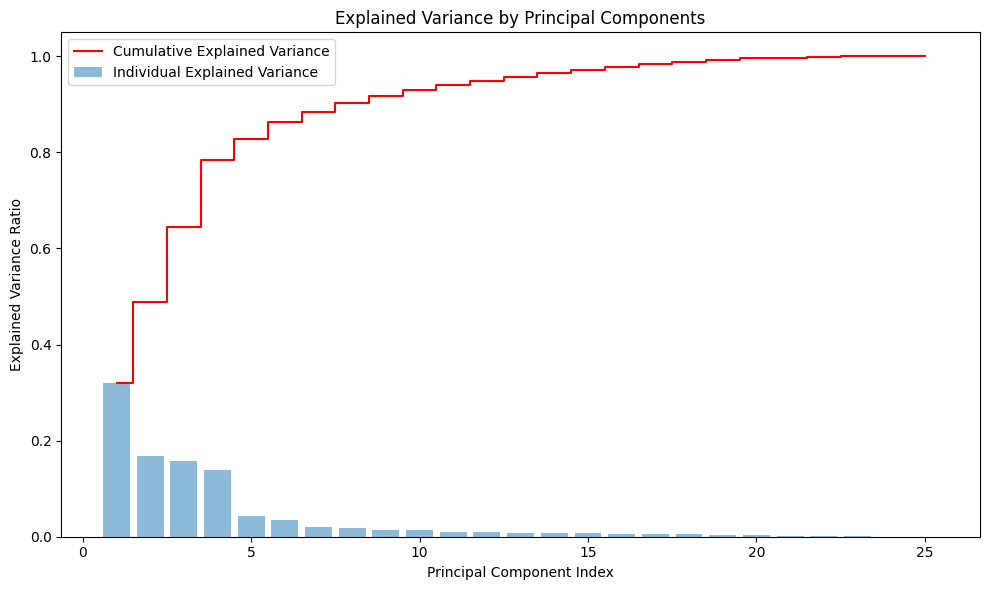

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA to calculate explained variance
pca = PCA(n_components=None)  # Keep all components to analyze explained variance
pca.fit(features_for_pca)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
        label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid',
         label='Cumulative Explained Variance', color='red')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### 2.2 Movie analysis

In the movie analysis using PCA, we represented three plots to explore how the principal components explain the variability in the data:

1. *Explained Variance*: The first plot shows the percentage of variance explained by the first two principal components. It is evident that PCA has captured a significant portion of the overall variability in the dataset, justifying the use of these components to reduce dimensionality.

2. *Movie Genres*: The second plot represents the PCA data grouped by the main genre. From this visualization, there is a noticeable tendency for some genres to cluster in certain areas of the principal components, but the separation is not clear-cut for all genres. Genres like Drama or Comedy show some concentration, while others, such as Adventure, appear more spread out.

3. *Release Decades*: The third plot groups the movies by their release decade. However, the distribution of the points does not clearly show a strong correlation between the decades and the principal components. The relationship between the release decade and the variability explained by PCA does not seem immediate.

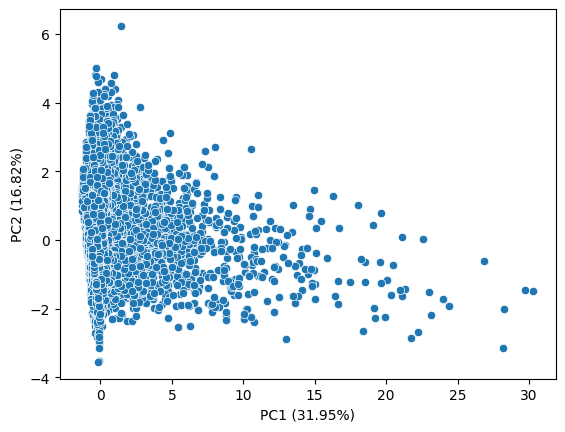

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualizzazione del grafico di dispersione per le prime due componenti principali
g = sns.scatterplot(x=reduced_features_df['PC1'], y=reduced_features_df['PC2'])

# Aggiungi le etichette per le componenti principali
g.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
g.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

# Salva e mostra il grafico
plt.savefig("PCA_without_loadings.png", dpi=200)
plt.show()


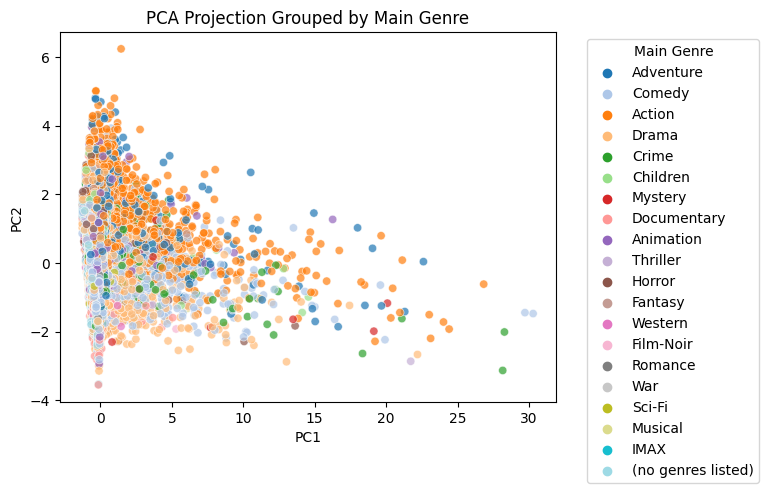

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggiungi una colonna con il primo genere per ogni film (o un altro criterio a tua scelta)
reduced_features_df['main_genre'] = movies_features['genres_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# Crea un grafico a dispersione raggruppato per il genere principale
sns.scatterplot(data=reduced_features_df, x='PC1', y='PC2', hue='main_genre', alpha=0.7, palette='tab20')

# Aggiungi il titolo e mostra il grafico
plt.title("PCA Projection Grouped by Main Genre")
plt.legend(title='Main Genre', bbox_to_anchor=(1.05, 1), loc='upper left')  # Posiziona la legenda fuori
plt.show()


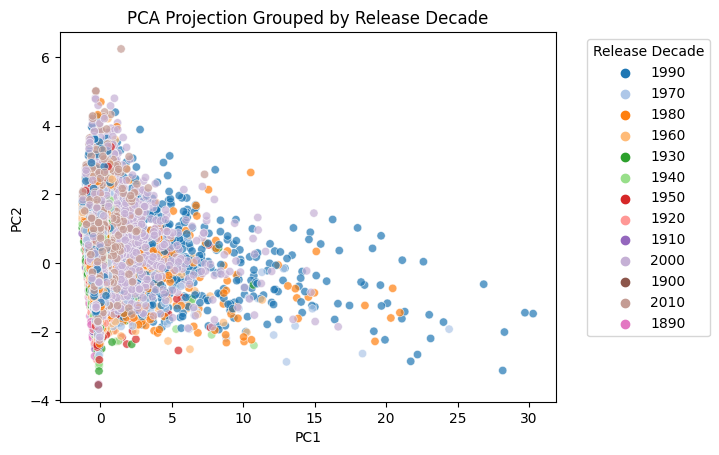

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert release_year into categories (decades)
reduced_features_df['release_decade'] = (movies_features['release_year'] // 10) * 10  # Group by decade

# Convert the release_decade into categorical types
reduced_features_df['release_decade'] = reduced_features_df['release_decade'].astype(str)

# Create a scatter plot and group the points by release decade
sns.scatterplot(data=reduced_features_df, x='PC1', y='PC2', hue='release_decade', alpha=0.7, palette='tab20')

# Title and show the plot
plt.title("PCA Projection Grouped by Release Decade")
plt.legend(title='Release Decade', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside
plt.show()


In [22]:
columns_to_remove = ['movieId','main_genre','release_decade']
reduced_features_df = reduced_features_df.drop(columns=columns_to_remove)

In [23]:
reduced_features_df

,PC1,PC2,PC3,PC4,PC5,PC6
0,22.611695,0.036184,-1.761401,3.064103,-0.545549,0.468057
1,9.807106,0.100464,-1.130002,1.708060,-0.094755,-0.239761
2,5.341237,-0.275285,-0.974106,1.169523,-0.633886,0.722885
3,1.038753,0.928200,0.142732,-0.042446,0.004004,1.171133
4,4.844834,-0.897078,-1.517250,1.609153,-0.571656,0.367074
...,...,...,...,...,...,...
27273,-0.304295,-1.224973,-0.781276,-0.956850,-0.913223,0.183676
27274,-0.307645,-1.286025,-0.607736,-0.848865,-0.917926,0.172678
27275,-0.674111,0.243039,-1.524814,0.510058,-0.090401,-0.289164
27276,-0.587652,-0.453285,-0.949002,0.273242,-0.137198,-0.304397


# 2.3 Clustering

## 2.3.1

- Firstly, we chose to use the *Elbow Graph* to identify the optimal point, known as the "elbow" of the graph, which represents the number of clusters beyond which the reduction in the mean squared error is no longer significant. This approach allows us to select the number of clusters rationally, avoiding the inclusion of unnecessary clusters.                          
- Subsequently, we calculated the *Silhouette Score*, a metric that reflects how close points within a cluster are to each other and how well-separated they are from points in other clusters, providing an indication of the quality of the clustering.

As for *Agglomerative Clustering*, we initially used it to observe how the data clusters at various distance levels by generating a dendrogram. We decided to cut the dendrogram at a distance of approximately 250, based on the analysis of distances between clusters in the dendrogram. Here as well, we calculated the Silhouette Score to assess the quality of the clusters obtained.

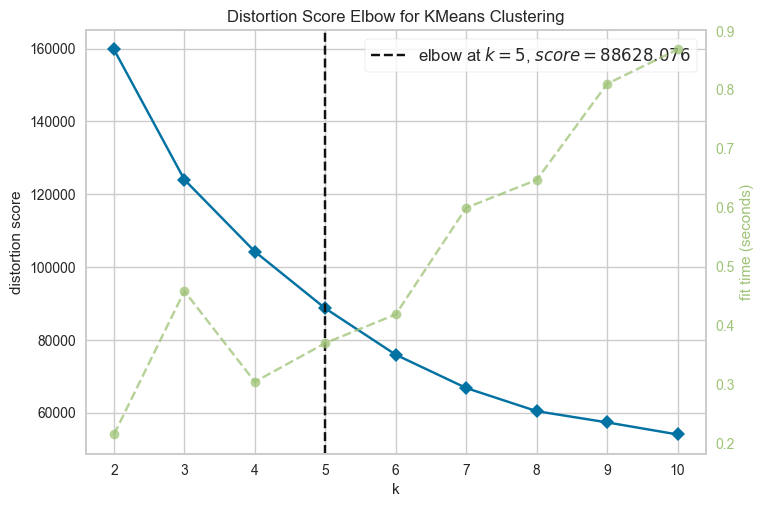

Optimal number of clusters (from KElbowVisualizer): 5
Silhouette Score for KMeans: 0.248


c:\Users\User\.pymod\pymod_envs\pymod_env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


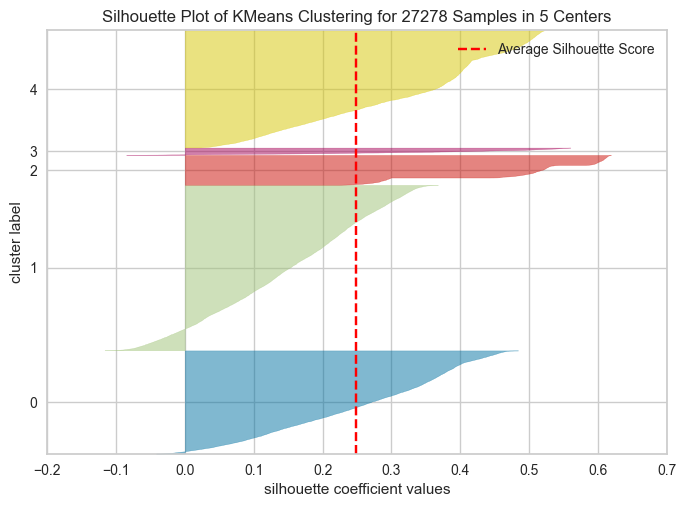

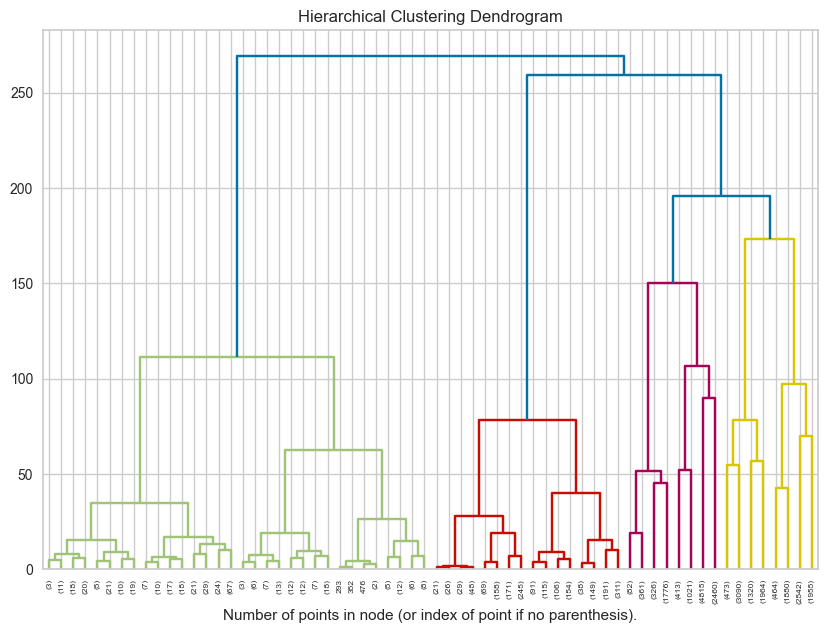

Silhouette Score for Agglomerative Clustering: 0.424


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram

# Load and preprocess your data
data = reduced_features_df
# KMeans Clustering with KElbowVisualizer
kmeans = KMeans(init='k-means++', random_state=42)

# Create a KElbowVisualizer to automatically determine the optimal number of clusters
visualizer = KElbowVisualizer(kmeans, k=(2, 11))  # Range from 2 to 10 clusters
visualizer.fit(data)  # Fit the model to the data
visualizer.show()  # Show the plot

# Get the optimal k from the visualizer
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters (from KElbowVisualizer): {optimal_k}")

# Fit the KMeans model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(data)

# Silhouette Score and Visualization for KMeans
print(f"Silhouette Score for KMeans: {silhouette_score(data, kmeans.labels_):.3f}")

# Plot Silhouette Visualizer for KMeans
plt.figure()
silhouette_visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
silhouette_visualizer.fit(data)
silhouette_visualizer.show()

# Hierarchical Clustering (Agglomerative)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

# AgglomerativeClustering model (Hierarchical Clustering)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(data)

# Plot the Dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
linkage_matrix = plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Agglomerative Clustering with optimal clusters
optimal_k_agglomerative = 3  # Replace with the number you selected
model_agglomerative = AgglomerativeClustering(n_clusters=optimal_k_agglomerative)
labels_agglomerative = model_agglomerative.fit_predict(data)

# Silhouette Score for Agglomerative Clustering
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_score(data, labels_agglomerative):.3f}")




## 2.3.2 and 2.3.3

The two K-means algorithms we implemented show significant differences in their initialization strategies and overall performance. 
1. **K-means**: K-means with random initialization selects centroids randomly from the dataset without considering the data distribution.                                                                                                                                                                   

2. **K-means++**: K-means++ starts with a randomly chosen centroid, but the subsequent centroids are selected based on their distance from the already chosen ones, favoring points that are farther apart. This approach improves the final cluster quality and reduces the likelihood of convergence to local minima.

- **Performance**:  K-means++ has a higher initialization time due to its more complex selection process, whereas K-means with random initialization is faster because of its simplicity and the lack of computations during the initial phase. K-means++ is slower only during the initialization phase due to its more complex process of selecting centroids based on data distribution. However, in all subsequent steps, such as assignment and updating, it is faster compared to the random initialization approach.

In [25]:
import pandas as pd
from kmeans_algorithm import kmeans_random, kmeans_plus_plus

# Assuming reduced_features_df is your DataFrame
X = reduced_features_df

# Parameters
k = 4
iterations = 10

# K-means with random initialization
results_random = kmeans_random(X, k, iterations)
print("\n--- K-means with Random Initialization ---")
print(f"Total Time: {results_random['total_time']:.4f} s")
print(f"Initialization Time: {results_random['init_time']:.4f} s")
print(f"Point Assignment Time: {results_random['assign_time']:.4f} s")
print(f"Centroid Recalculation Time: {results_random['update_time']:.4f} s")

# K-means++ with k-means++ initialization
results_plus_plus = kmeans_plus_plus(X, k, iterations)
print("\n--- K-means++ with K-means++ Initialization ---")
print(f"Total Time: {results_plus_plus['total_time']:.4f} s")
print(f"Initialization Time: {results_plus_plus['init_time']:.4f} s")
print(f"Point Assignment Time: {results_plus_plus['assign_time']:.4f} s")
print(f"Centroid Recalculation Time: {results_plus_plus['update_time']:.4f} s")




--- K-means with Random Initialization ---
Total Time: 2.3738 s
Initialization Time: 0.0207 s
Point Assignment Time: 0.0485 s
Centroid Recalculation Time: 2.3046 s

--- K-means++ with K-means++ Initialization ---
Total Time: 3.5035 s
Initialization Time: 1.1799 s
Point Assignment Time: 0.0692 s
Centroid Recalculation Time: 2.2545 s


## 2.3.4

*Response from the LLM (ChatGPT or similar):*
How DBSCAN Works:
- DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.
- It requires two parameters:
- Epsilon (ε): The maximum distance between two points for them to be considered neighbors.
MinPts: The minimum number of points required to form a dense region (a cluster).

Key Steps in DBSCAN:

- Core Points: If a point has at least MinPts points (including itself) within its ε-neighborhood, it is classified as a core point.
- Border Points: Points that are not core points but are within the ε-neighborhood of a core point are classified as border points.
- Noise Points: Points that are neither core nor border points are classified as noise.
- The algorithm expands clusters from core points, and any point that is reachable from a core point becomes part of the same cluster. This process helps identify clusters of arbitrary shape, unlike K-means, which assumes spherical clusters.


Advantages of DBSCAN over K-means and K-means++:
- Does not require specifying the number of clusters (k) beforehand.
- Can detect clusters of arbitrary shape (unlike K-means, which assumes spherical clusters).
- Handles noise well, as it can label outliers (points that don’t belong to any cluster).
- Robust to outliers: DBSCAN doesn’t force every point into a cluster, which is useful for datasets with noise.

Disadvantages of DBSCAN compared to K-means:
- Sensitive to the choice of parameters (ε and MinPts): If these parameters are not chosen carefully, DBSCAN may either over-segment or fail to detect meaningful clusters.
- Not suitable for clusters with varying density: If the data has clusters of varying density, DBSCAN might have trouble.
- Scalability: DBSCAN can be computationally expensive on very large datasets (though optimizations exist).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def perform_dbscan_clustering(data, eps=0.3, min_samples=100):
    """
    Perform DBSCAN clustering on the provided data and visualize the results.

    Parameters:
    - data: DataFrame containing the features for clustering (excluding 'movieId').
    - eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
    - clusters: The cluster labels for each point in the dataset.
    """
    
   
    X = data.drop(columns=['movieId'], errors='ignore')

    # DBSCAN application
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

   
    data['dbscan_cluster'] = clusters

    # Calculate number of clusters found 
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = (clusters == -1).sum()
    
    print(f"Numero di cluster trovati: {n_clusters}")
    print(f"Numero di punti considerati rumore: {n_noise}")

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
    plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.colorbar(label='Cluster')
    plt.show()

    return clusters

clusters = perform_dbscan_clustering(reduced_features_df, eps=0.3, min_samples=100)

Estimated number of clusters: 67
Estimated number of noise points: 7031


In [40]:
# Adjust DBSCAN parameters
eps_values = [0.2, 0.3, 0.5, 0.5]  # Experiment with different eps values
min_samples_values = [5, 10, 20, 100]  # Experiment with different min_samples values

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nDBSCAN with eps={eps}, min_samples={min_samples}")
        
        # Run DBSCAN with adjusted parameters
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = db.labels_
        
        # Calculate the number of clusters and noise points
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)



DBSCAN with eps=0.2, min_samples=5
Estimated number of clusters: 265
Estimated number of noise points: 9187

DBSCAN with eps=0.2, min_samples=10
Estimated number of clusters: 102
Estimated number of noise points: 12925

DBSCAN with eps=0.2, min_samples=20
Estimated number of clusters: 56
Estimated number of noise points: 16979

DBSCAN with eps=0.2, min_samples=100
Estimated number of clusters: 2
Estimated number of noise points: 24137

DBSCAN with eps=0.3, min_samples=5
Estimated number of clusters: 163
Estimated number of noise points: 4636

DBSCAN with eps=0.3, min_samples=10
Estimated number of clusters: 67
Estimated number of noise points: 7031

DBSCAN with eps=0.3, min_samples=20
Estimated number of clusters: 45
Estimated number of noise points: 9993

DBSCAN with eps=0.3, min_samples=100
Estimated number of clusters: 7
Estimated number of noise points: 20351

DBSCAN with eps=0.5, min_samples=5
Estimated number of clusters: 60
Estimated number of noise points: 1698

DBSCAN with ep

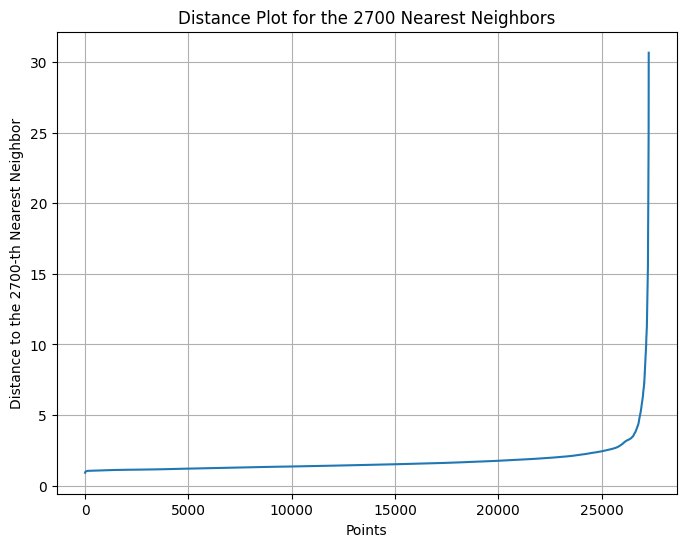

In [27]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calculate the k-th nearest neighbor distances (e.g., k=2700)
k = 2700
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances in ascending order
distances = np.sort(distances[:, -1], axis=0)

# Plot the distances
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title(f'Distance Plot for the {k} Nearest Neighbors')
plt.xlabel('Points')
plt.ylabel(f'Distance to the {k}-th Nearest Neighbor')
plt.grid(True)
plt.show()


## 2.4 Best Algorithm


- The Silhouette Score evaluates how well a point fits within its assigned cluster compared to other clusters. Scores range from -1 to 1, with higher values indicating better separation between clusters. In this analysis, DBSCAN achieves the highest score, suggesting its clusters are well-separated. K-means++ and K-means (sklearn) show similar performance, while K-means (random) has the lowest score, indicating weaker clustering quality.

 
- The Davies-Bouldin Index assesses clustering quality based on the distance between clusters and the dispersion within each cluster. Lower values indicate better clustering. DBSCAN again outperforms other methods with the lowest index, showing strong separation between clusters. K-means++ and K-means (sklearn) follow closely, while K-means (random) shows the highest index, implying poorer clustering quality.
 
- This index measures the compactness and separation of clusters, with higher values indicating better performance. K-means (sklearn) and K-means++ demonstrate the strongest performance here, followed by K-means (random). DBSCAN, while strong in other metrics, achieves the lowest score on this index, reflecting less compact clusters compared to the K-means variants.  


| Algorithm          | Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index |
|---------------------|------------------|-----------------------|-------------------------|
| K-means (random)   | 0.145788         | 2.667062              | 2318.932451            |
| K-means++          | 0.257740         | 2.230544              | 2720.303939            |
| DBSCAN             | 0.345376         | 1.813802              | 1426.901943            |
| K-means (sklearn)  | 0.257757         | 2.230473              | 2720.333672            |


In [162]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np

# Assicurati che X sia già definito e preprocessato
k_opt = 5  # Optimal number of clusters
dbscan = DBSCAN(eps=5, min_samples=270)  # Adjust parameters as needed
dbscan_clusters = dbscan.fit_predict(X)

# Evaluate clustering results
results = []

for algorithm, clusters in [
    ('K-means (random)', kmeans_random(X, k_opt)['centroids']),
    ('K-means++', kmeans_plus_plus(X, k_opt)['centroids']),
    ('DBSCAN', dbscan_clusters),
    ('K-means (sklearn)', KMeans(n_clusters=k_opt, init='k-means++', random_state=42).fit(X).labels_)]:  # Sklearn implementation
    
    # Assign cluster labels
    if algorithm in ['K-means (random)', 'K-means++']:
        distances = np.linalg.norm(X.values[:, None] - clusters, axis=2)
        cluster_labels = np.argmin(distances, axis=1)
    else:
        cluster_labels = clusters  # Per DBSCAN e KMeans sklearn sono già le etichette

    # Compute metrics
    if len(set(cluster_labels)) > 1:  # Ensure at least two clusters are present
        sil_score = silhouette_score(X, cluster_labels)
        db_index = davies_bouldin_score(X, cluster_labels)
        ch_index = calinski_harabasz_score(X, cluster_labels)
    else:
        sil_score = np.nan
        db_index = np.nan
        ch_index = np.nan

    results.append({
        'Algorithm': algorithm,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Index': ch_index
    })

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(results)
print(results_df)



           Algorithm  Silhouette Score  Davies-Bouldin Index  \
0   K-means (random)          0.228136              1.347991   
1          K-means++          0.219974              1.234166   
2             DBSCAN          0.858587              0.286914   
3  K-means (sklearn)          0.256274              1.125234   

   Calinski-Harabasz Index  
0              7522.218844  
1              8102.198063  
2              3911.283384  
3              8769.429193  


## 3. Bonus Question

We implemented two versions of the K-Means algorithm—one with random initialization and the other with K-Means++ initialization. By visualizing the first ten iterations for both approaches, we can observe notable differences in the clustering behavior.

1. **Random Initialization**:
With standard K-Means (random initialization), the centroids are selected without consideration for their spread or distance.
This can lead to initial centroids being relatively close to each other, as in this case. Consequently, it takes longer for the centroids to adjust and move apart progressively.
Even after several iterations, the clusters may remain less well-defined, as some points might not be clearly separated from other clusters. This inefficiency in initialization can result in a slower convergence and poorer cluster quality.
2. **K-Means++ Initialization**:
K-Means++ improves the initialization by ensuring that centroids are chosen with a certain distance from each other, based on a probabilistic approach.
This leads to centroids that are already well-dispersed from the start, increasing the likelihood of better cluster formation.
As a result, convergence is achieved more quickly—often noticeable within the first few iterations. Even before the tenth iteration, we can observe clearer cluster separations, as the centroids stabilize much earlier.
This also reduces the risk of poor clustering solutions caused by suboptimal initial positions of the centroids.


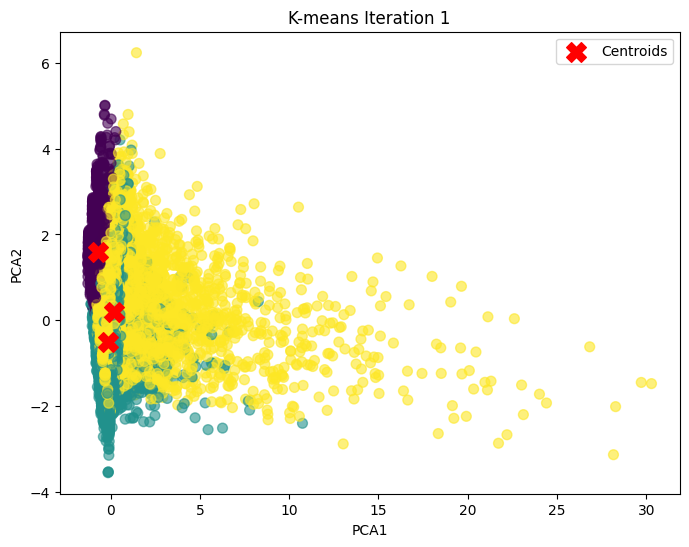

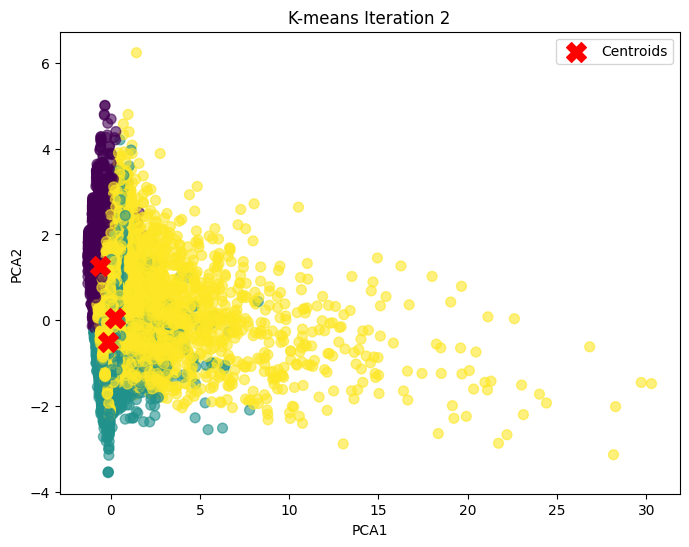

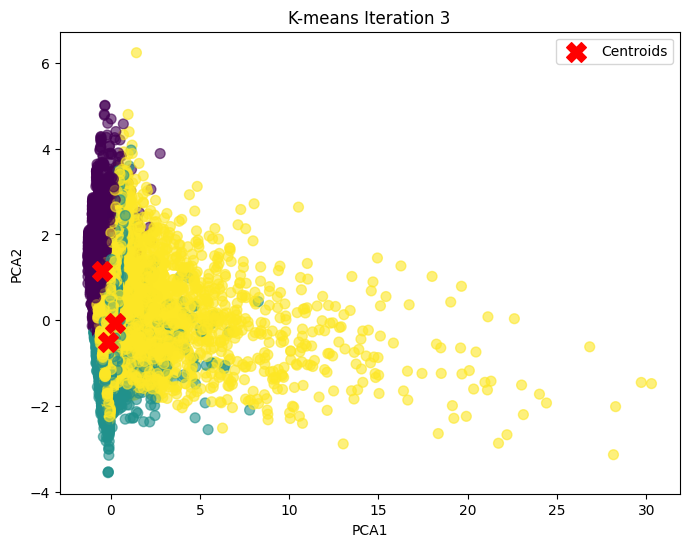

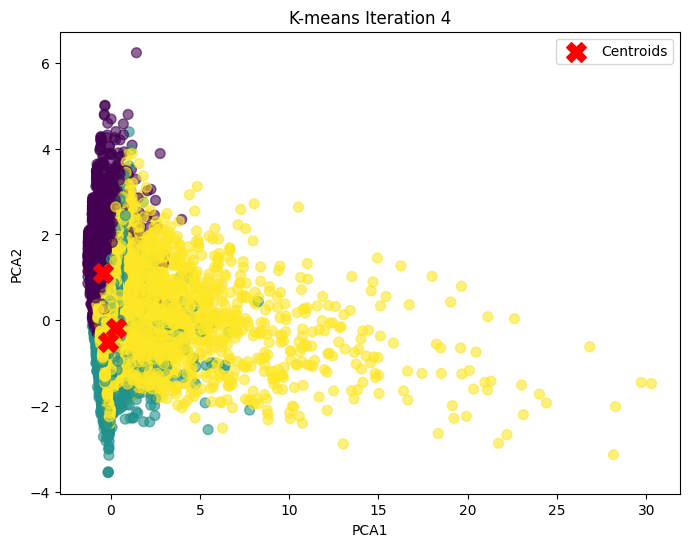

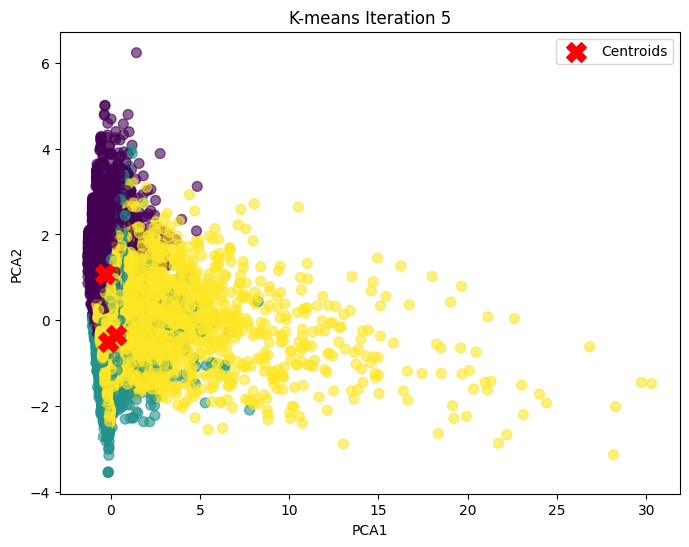

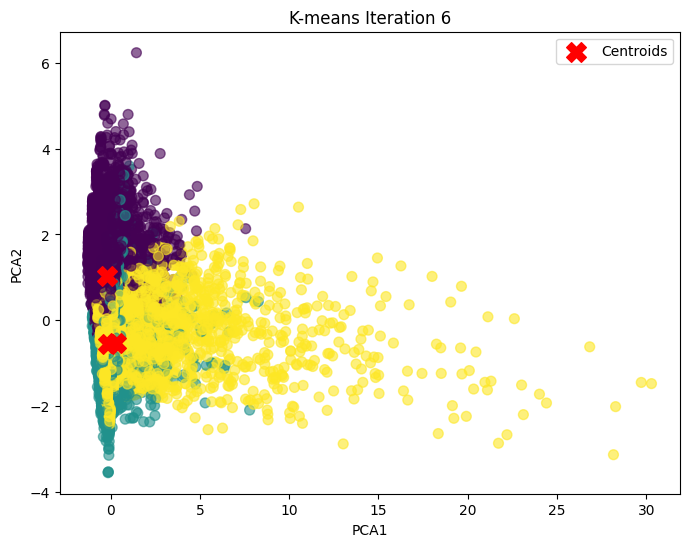

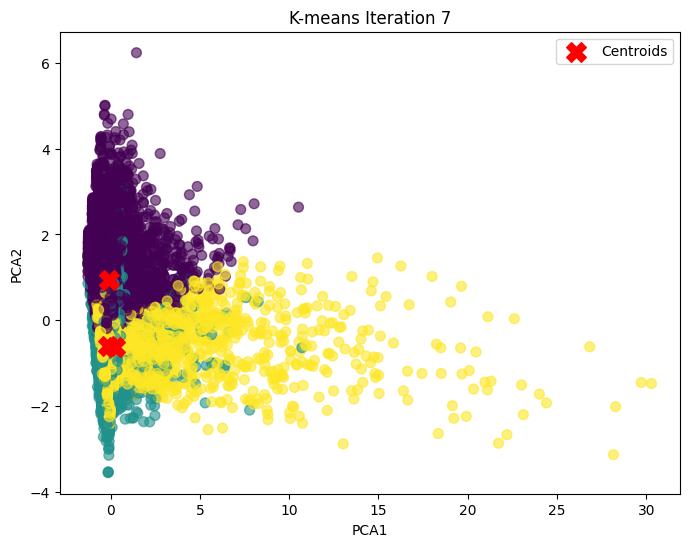

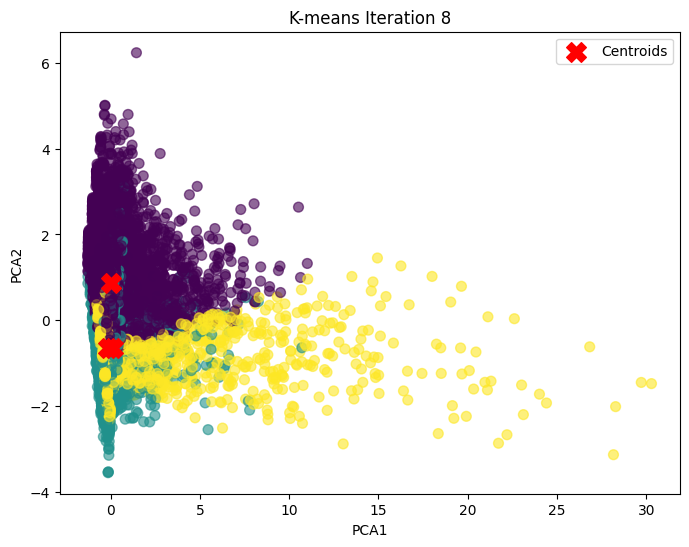

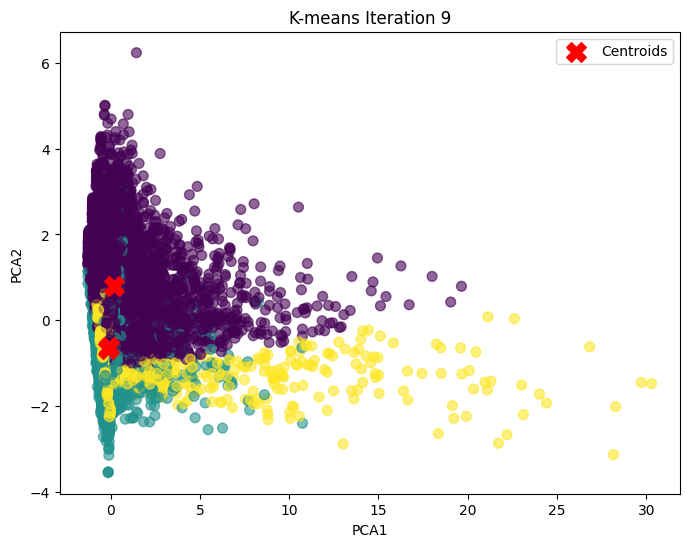

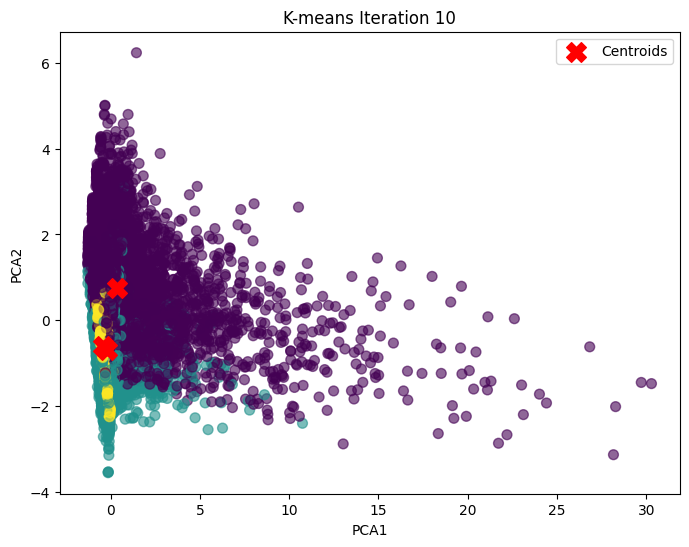

Final centroids after 10 iterations:
[[ 0.34175975  0.75067546 -0.19989369 -0.10168013 -0.04366298  0.01939429
  -1.        ]
 [-0.19400666 -0.68507347  1.01994654  0.44560911 -0.02046395 -0.02851394
  -0.94578908]
 [-0.41257446 -0.58884783 -0.86972359 -0.35267417  0.10817189 -0.00195831
   1.29665506]]


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

X = reduced_features_df

#number of clusters (K)
k = 3  
iterations = 10  #Number of iterations

# Random initialization of centroids
centroids = X.iloc[np.random.choice(len(X), k, replace=False)].values

# Function to map points to the closest centroid
def map_points_to_centroids(X, centroids):
    # Initialize a matrix to store distances between points and centroids
    distances = np.zeros((X.shape[0], k))
    
    # Compute distances between points and centroids
    for i in range(X.shape[0]):
        for j in range(k):
            # Calculate Euclidean distance between point and centroid
            diff = X.iloc[i] - centroids[j]
            distances[i, j] = np.sqrt(np.sum(np.square(diff)))
    
    # Assign each point to the closest centroid
    closed = np.argmin(distances, axis=1)
    return closed

# Function to recalculate centroids based on assigned points
def reduce_centroids(X, closed, k):
    # Group points by centroid
    centroids_list = [X[closed == j] for j in range(k)]
    
    # Compute new centroids as the mean of points assigned to each centroid
    new_centroids = np.array([np.mean(group, axis=0) if group.shape[0] > 0 else centroids[j] for j, group in enumerate(centroids_list)])
    
    return new_centroids

# K-means algorithm with MapReduce (convergence check)
prev_centroids = np.zeros_like(centroids)  # Initialize previous centroids
for iteration in range(iterations):
    # Map: Assign each point to the closest centroid
    closed = map_points_to_centroids(X, centroids)

    # Reduce: Recalculate centroids as the mean of assigned points
    new_centroids = reduce_centroids(X, closed, k)

    # Check for convergence (if centroids do not change significantly)
    if np.allclose(new_centroids, prev_centroids, atol=1e-4):
        print(f"Convergence reached at step {iteration + 1}")
        break

    # Update centroids for the next iteration
    prev_centroids = new_centroids.copy()
    centroids = new_centroids.copy()

    #visualization  at each iteration
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=closed, cmap='viridis', alpha=0.6, s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
    plt.title(f"K-means Iteration {iteration + 1}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

# Display the final centroids
print("Final centroids after", iteration + 1, "iterations:")
print(centroids)


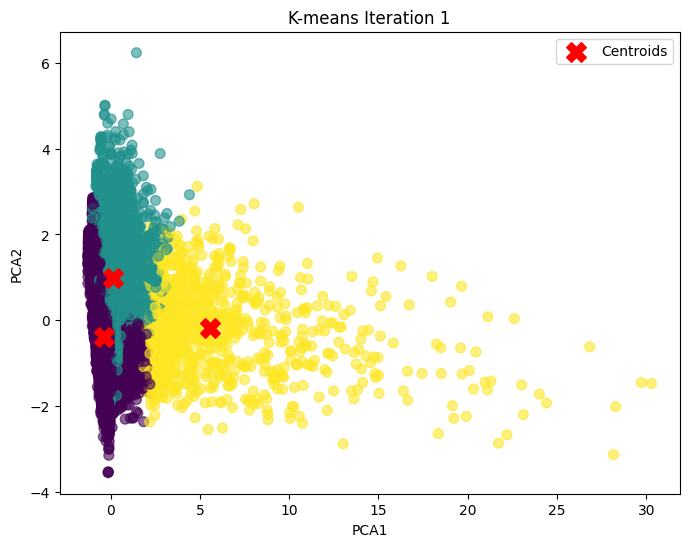

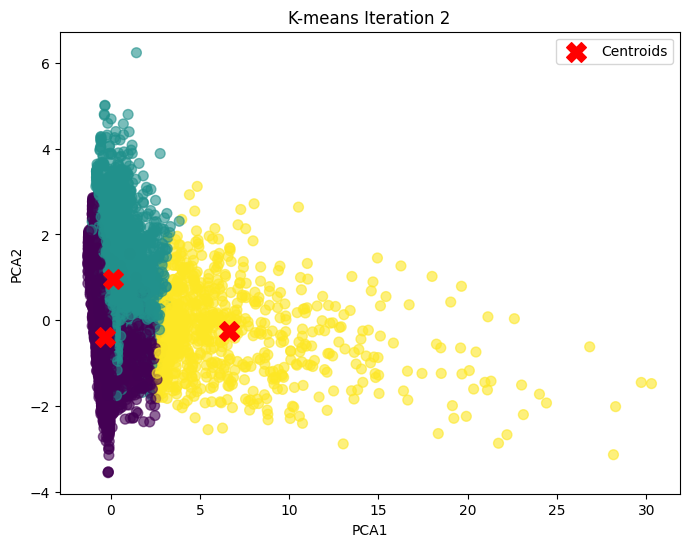

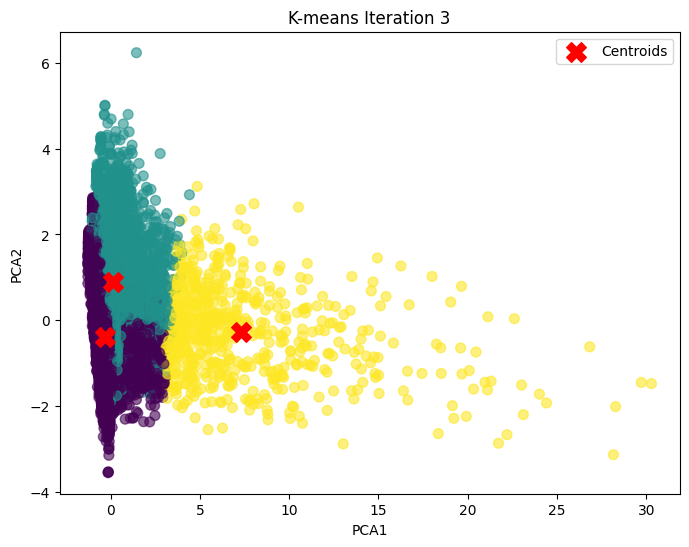

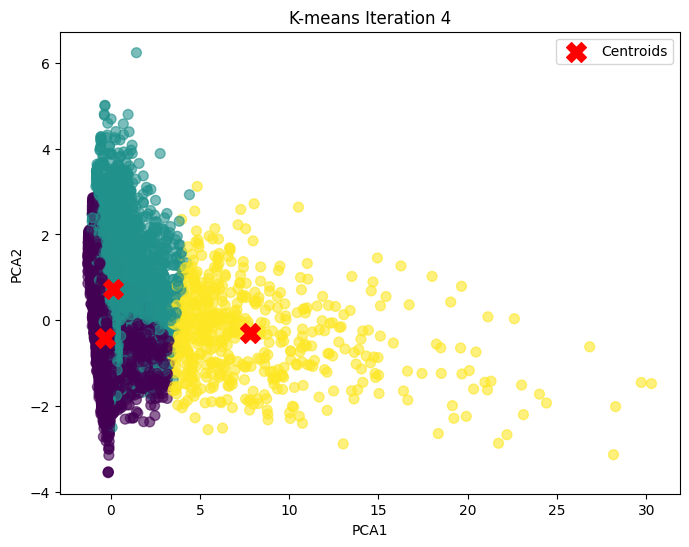

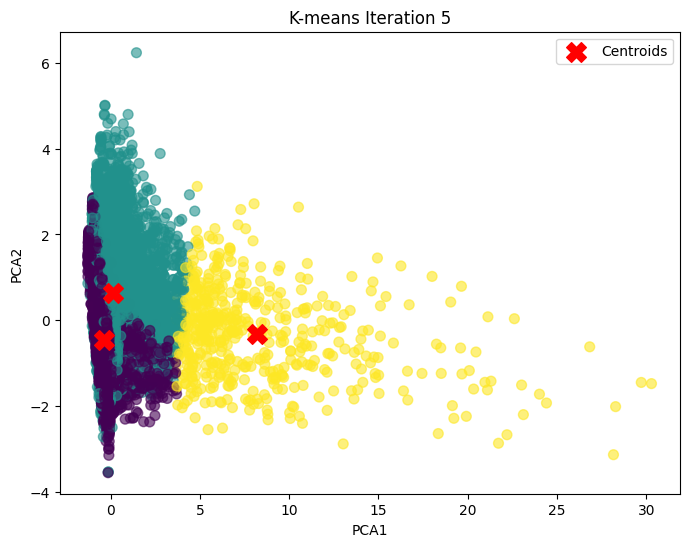

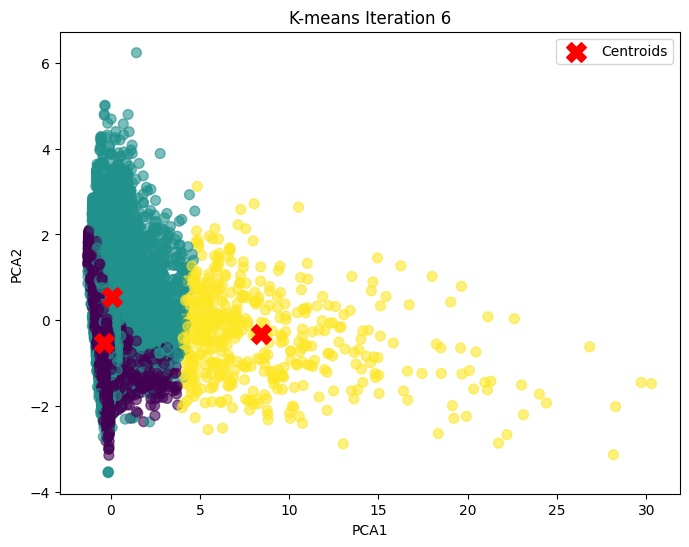

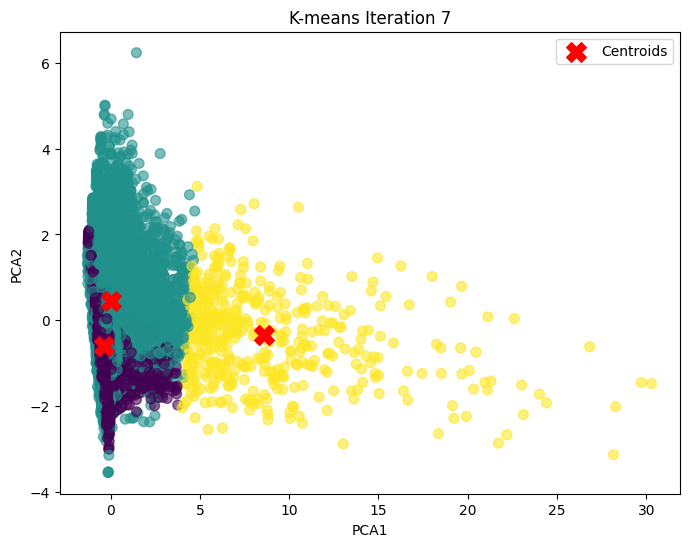

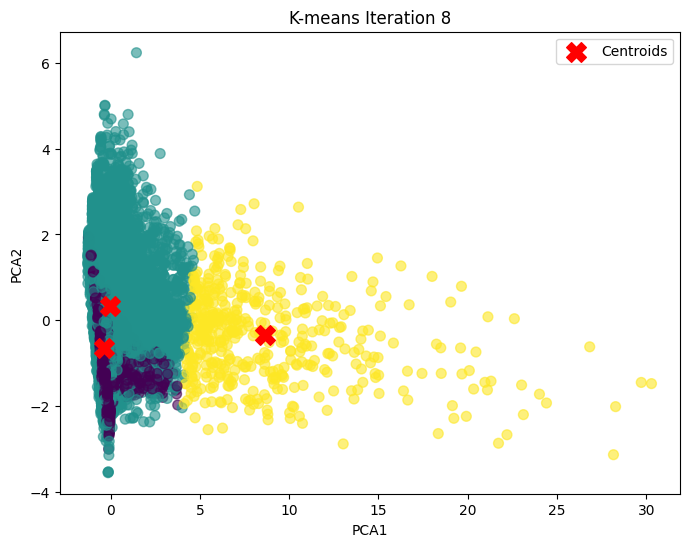

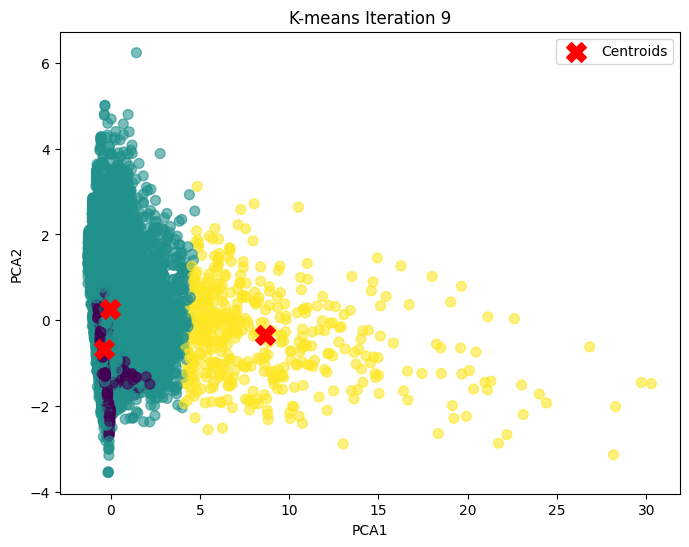

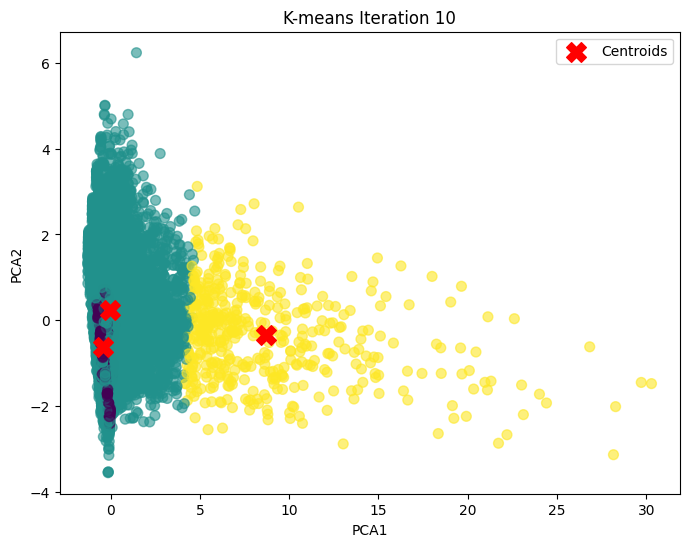

Final centroids: [[-4.12067123e-01 -6.31253263e-01 -8.11582034e-01 -3.35039506e-01
   1.24325257e-01 -8.18876354e-04  1.22289157e+00]
 [-5.89504082e-02  2.29733816e-01  3.01228762e-01  9.36889023e-02
  -4.46408405e-02  1.23481552e-04 -9.94203629e-01]
 [ 8.67491005e+00 -3.36526094e-01 -6.82465013e-01  1.02383609e+00
   4.05119828e-02  6.99427456e-03 -1.00000000e+00]]


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

# Function to initialize centroids using the k-means++ method
def kmeans_plus_plus_init(X, k):
    # Select the first centroid randomly
    centroids = [X.iloc[np.random.choice(len(X))].values]
    
    # Select the remaining centroids
    for _ in range(1, k):
        # Calculate the squared distance of each point to its nearest centroid
        distances = np.array([min(np.linalg.norm(x - c) ** 2 for c in centroids) for x in X.values])
        
        # Calculate selection probabilities based on squared distances
        probs = distances / distances.sum()
        
        # Select the next centroid probabilistically
        cumulative_probs = probs.cumsum()
        r = np.random.rand()  # Generate a random number between 0 and 1
        next_centroid = X.iloc[np.searchsorted(cumulative_probs, r)].values
        centroids.append(next_centroid)
    
    return np.array(centroids)

X = reduced_features_df


k = 3

# Initialize centroids using k-means++ initialization
centroids = kmeans_plus_plus_init(X, k)

# Function to map each point to the closest centroid
def map_points_to_centroids(X, centroids):
    # Initialize a matrix to store distances between points and centroids
    distances = np.zeros((X.shape[0], k))
    
    # Compute distances between points and centroids
    for i in range(X.shape[0]):
        for j in range(k):
            diff = X.iloc[i].values - centroids[j]
            distances[i, j] = np.sqrt(np.sum(np.square(diff)))  # Compute Euclidean distance
    
    # Assign each point to the closest centroid
    closed = np.argmin(distances, axis=1)
    return closed

# Function to calculate new centroids as the mean of assigned points
def reduce_centroids(X, closed, k):
    # Group points by their assigned centroid
    centroids_list = [X[closed == j] for j in range(k)]
    
    # Calculate new centroids as the mean of the points in each group
    new_centroids = np.array([np.mean(group, axis=0) if group.shape[0] > 0 else centroids[j] for j, group in enumerate(centroids_list)])
    
    return new_centroids

# K-means algorithm with MapReduce logic (convergence check)
prev_centroids = np.zeros_like(centroids)  # Initialize previous centroids
for iteration in range(10):  
    # Map: Assign each point to the closest centroid
    closed = map_points_to_centroids(X, centroids)

    # Reduce: Calculate new centroids as the mean of assigned points
    centroids = reduce_centroids(X, closed, k)

    # Check for convergence (if centroids do not change significantly)
    if np.allclose(centroids, prev_centroids, atol=1e-4):
        print(f"Convergence reached at iteration {iteration + 1}")
        break

    # Update previous centroids for the next iteration
    prev_centroids = centroids.copy()

    # Visualize the results for each iteration
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=closed, cmap='viridis', alpha=0.6, s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
    plt.title(f"K-means Iteration {iteration + 1}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

# Display the final centroids
print("Final centroids:", centroids)
